# Data Preparation and Analysis Notebook
## Defining the representation, data extraction, cleaning, preprocessing, and visualisation

In this Jupyter notebook we first need to define the representation that we will be using for our model.

One approach is to consider the fragmentation of the tumour via its cancer cells. If the cancer cells are highly clustered, then the T cells will have an easier time containing their spread and thus reducing the likelihood of penetration into the bloodstream. If this happens then the cancer can spread rapidly and increase the likelihood of a fatality. 

Following from this idea of fragmentation, the idea is to define a neighbouring relation between cells. If they are close enough to each other, we say that they are in the same 'bud', or 'cluster'. A cluster is then defined as a collection of cells where for each c in the cluster, there exists another cell c' such that c and c' are neighbours according to our neighbouring relation.

We'll take a histogram of the frequencies of the sizes of these clusters, from 1 to 20 and 21+. This gives us a homogenous, relatively low-dimensional (n=21) input to our classifier.

## TODO: Clarify the different types of data ## 
The data is passed in as a large Excel file with various fields. Once those were cleaned up, we had just 8 columns, being xMin, xMax, yMin, yMax of the bounding boxes surrounding the cells, and three classes indicating whether the cell was a cancer cell, a general T cell, or a cytotoxic T cell. Note that 'lymphocytes' are a superset of T cells.

Now that we've defined a feature representation to give to our model, let's go about getting our representation.

In [ ]:
# Watermark for reproducibility of results
%load_ext watermark
%watermark -a 'Daniel Soutar' -d -nrmv --packages numpy, pandas,sklearn,matplotlib,seaborn,imblearn

In [1]:
# Imports
import Cluster
import csv
import cProfile
import glob
import Loader
import partition
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import pandas as pd
import seaborn as sb
from imblearn.over_sampling import ADASYN, SMOTE

# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [ ]:
## Loading
example = open("./examples/_DONEIN700-SN142.p", 'rb')
input_list = pickle.load(example)
example.close()
print(len(input_list))

In [ ]:
# Splitting cells up by their class
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    conv_row = [ int(x) for x in row[0:-1] ]
    conv_row.append(float(row[-1]))
    
    if conv_row[4] > 0 and conv_row[-1] > 50.0:  # filter out cells that are too small - those are blood cells!
        cancer_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
    if conv_row[5] > 0:
        T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
    if conv_row[6] > 0:
        cyto_T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)
print(cancer_cells.shape)

In [ ]:
# Let's first visualise the input to make sure our data 'looks' as we would expect it to.
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

Now let's move the above functionality into some functions. Note that we have several different kinds
of data and might want to filter our data. So let's use lambdas and several input formats to filter in 
a generic way.

In [17]:
# Generic function for loading from pickle files
def load_data(src, path, pretty_print=True):
    example = open(path + src + ".p", 'rb')
    input_list = pickle.load(example)
    example.close()
    if pretty_print:
        print("Size of input list: ", len(input_list))
    return input_list

# Annoyingly have a different representation (csv) for these files, but space constraints require it.
def load_lymphocytes(src, path, pretty_print=True):
    reader = csv.reader(open(path + src + ".csv", "r"), delimiter=",")
    input_list = list(reader)
    if pretty_print:
        print("Size of input list: ", len(input_list))
    return input_list
    
# This function might need to filter cells within a range - let's do that at the beginning by passing in
# filters.
def split_original(input_list, fxMin=None, fxMax=None, fyMin=None, fyMax=None, fcell_size=None, pretty_print=True):
    cancer_cells = []
    T_cells = []
    cyto_T_cells = []
    
    # Order is xMin, xMax, yMin, yMax, have to do cell_size separately because there are other fields.
    funcs = [fxMin, fxMax, fyMin, fyMax]
    
    for i, row in enumerate(input_list):
        conv_row = [ int(x) for x in row[0:-1] ]
        conv_row.append(float(row[-1]))
        
        include_cell = True
        
        if conv_row[4] > 0:
            for i, f in enumerate(funcs):
                if f is None:
                    continue
                else:
                    if not f(conv_row[i]):
                        include_cell = False
                        break
            if include_cell:
                if f5 is not None:
                    if f5(conv_row[-1]):
                        cancer_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
                else:
                    cancer_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])

        if conv_row[5] > 0:
            T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])
        if conv_row[6] > 0:
            cyto_T_cells.append([conv_row[0], conv_row[1], conv_row[2], conv_row[3]])

    if pretty_print:
        print("Number of cancer cells:", len(cancer_cells))
    cancer_cells = np.asarray(cancer_cells)
    T_cells = np.asarray(T_cells)
    cyto_T_cells = np.asarray(cyto_T_cells)
    return cancer_cells, T_cells, cyto_T_cells

# As above with split_original, but uses num_cells instead of cell sizes
def split_new(input_list, fxMin=None, fxMax=None, fyMin=None, fyMax=None, fnum_cells=None, pretty_print=True):

    cancer_clusters = []
    # Order of items in each entry is num_cells, xMax, xMin, yMax, yMin, so need to reorder our filters
    funcs = [fnum_cells, fxMax, fxMin, fyMax, fyMin]
    
    for i, row in enumerate(input_list):
        row = [ int(x) for x in row ]
        include_cluster = True

        for i, f in enumerate(funcs):
            if f is None:
                continue
            else:
                if not f(row[i]):
                    include_cluster = False
                    break
        if include_cluster:
            cancer_clusters.append([row[0], row[2], row[1], row[4], row[3]])

    if pretty_print:
        print("Number of cancer clusters:", len(cancer_clusters))
    cancer_clusters = np.asarray(cancer_clusters)

    return cancer_clusters

# As above with split_new, but collects lymphocytes, not cancer clusters.  
# Note that we include the binary vectors indicating the type of cell - this is so I can more easily
# combine them and split them later.
def split_new_lymphocytes(input_list, fxMin=None, fxMax=None, fyMin=None, fyMax=None, pretty_print=True):
    cd3_cells = []
    cd8_cells = []
    # These are the easiest - no other fields, just filter these values.
    funcs = [fxMin, fxMax, fyMin, fyMax]
    
    for i, row in enumerate(input_list):
        row = [ int(x) for x in row ]
        include_cell = True

        for i, f in enumerate(funcs):
            if f is None:
                continue
            else:
                if not f(row[i]):
                    include_cell = False
                    break
        if include_cell:
            if row[-2] > 0:
                cd3_cells.append([row[0], row[1], row[2], row[3], row[4], row[5]])  
            elif row[-1] > 0:
                cd8_cells.append([row[0], row[1], row[2], row[3], row[4], row[5]])
                
    if pretty_print:
        print("Number of CD3 cells:", len(cd3_cells))
        print("Number of CD8 cells:", len(cd8_cells))
    cd3_cells = np.asarray(cd3_cells)
    cd8_cells = np.asarray(cd8_cells)

    return cd3_cells, cd8_cells


def visualise_original(cancer_cells=None, T_cells=None, cyto_T_cells=None, single_image=False):
    if not single_image:
        cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
        cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

        T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
        T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

        cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
        cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

        ax1.set_title('Cancer cells', fontsize=30)
        ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

        ax2.set_title('T cells', fontsize=30)
        ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

        ax3.set_title('Cytotoxic T cells', fontsize=30)
        ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

        plt.show(fig)
    else:
        cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
        cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

        fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

        ax1.set_title('Cancer cells', fontsize=30)
        ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

        plt.show(fig)


def visualise_new(cancer_clusters, size_included=True, size=(10, 10)):
    if size_included:
        i, j, k, l = 1, 2, 3, 4
    else:
        i, j, k, l = 0, 1, 2, 3
    cancer_clusters_xAvg = np.mean(np.array([cancer_clusters[:,i], cancer_clusters[:,j]]), axis=0)
    cancer_clusters_yAvg = np.mean(np.array([cancer_clusters[:,k], cancer_clusters[:,l]]), axis=0)

    fig, ax1 = plt.subplots(1, 1, figsize=size)

    ax1.set_title('Cancer clusters', fontsize=20)
    ax1.scatter(cancer_clusters_xAvg, cancer_clusters_yAvg, s=5, c='b')

    plt.show(fig)


def visualise_new_lymphocytes(cd3_cells, cd8_cells):
    cd3_cells_xAvg = np.mean(np.array([cd3_cells[:,0], cd3_cells[:,1]]), axis=0)
    cd3_cells_yAvg = np.mean(np.array([cd3_cells[:,2], cd3_cells[:,3]]), axis=0)

    cd8_cells_xAvg = np.mean(np.array([cd8_cells[:,0], cd8_cells[:,1]]), axis=0)
    cd8_cells_yAvg = np.mean(np.array([cd8_cells[:,2], cd8_cells[:,3]]), axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
    
    ax1.set_title('CD3 cells', fontsize=30)
    ax1.scatter(cd3_cells_xAvg, cd3_cells_yAvg, s=0.1, c='r')

    ax2.set_title('CD8 cells', fontsize=30)
    ax2.scatter(cd8_cells_xAvg, cd8_cells_yAvg, s=0.1, c='g')

    plt.show(fig)


def load_split(src, path, fxMin=None, fxMax=None,
                         fyMin=None, fyMax=None,
                         fcell_size=lambda x : x >= 50.0,
                         fnum_cells=lambda x : x > 0,
                         input_type="Cluster", pretty_print=True):
    if pretty_print:
        print(src)
    if input_type == "Cluster":
        input_list = load_data(src, path, pretty_print=pretty_print)
        cancer_cells, T_cells, cyto_T_cells = split_original(input_list, fxMin=fxMin,
                                                             fxMax=fxMax, fyMin=fyMin,
                                                             fyMax=fyMax, fcell_size=fcell_size,
                                                             pretty_print=pretty_print)
        return cancer_cells, T_cells, cyto_T_cells
    elif input_type == "cluster":
        input_list = load_data(src, path, pretty_print=pretty_print)
        cancer_clusters = split_new(input_list, fxMin=fxMin, fxMax=fxMax,
                                    fyMin=fyMin, fyMax=fyMax, fnum_cells=fnum_cells,
                                    pretty_print=pretty_print)
        return cancer_clusters
    elif input_type == "lymphocyte":
        input_list = load_lymphocytes(src, path, pretty_print=pretty_print)
        cd3_cells, cd8_cells = split_new_lymphocytes(input_list, fxMin=fxMin, fxMax=fxMax,
                                                     fyMin=fyMin, fyMax=fyMax, pretty_print=pretty_print)
        return cd3_cells, cd8_cells


def load_split_visualise(src, path, fxMin=None, fxMax=None,
                         fyMin=None, fyMax=None,
                         fcell_size=lambda x : x >= 50.0,
                         fnum_cells=lambda x : x > 0,
                         input_type="Original",
                         single_image=False):
    
    print(src)
    if input_type == "Original":
        cancer_cells, T_cells, cyto_T_cells = load_split(src, path, fxMin=fxMin, fxMax=fxMax,
                                                         fyMin=fyMin, fyMax=fyMax, fcell_size=fcell_size)
        visualise_original(cancer_cells=cancer_cells, T_cells=T_cells,
                           cyto_T_cells=cyto_T_cells, single_image=single_image)
    elif input_type == "cluster":
        cancer_clusters = load_split(src, path, fxMin=fxMin, fxMax=fxMax,
                                    fyMin=fyMin, fyMax=fyMax, fnum_cells=fnum_cells)
        visualise_new(cancer_clusters)
    elif input_type == "lymphocyte":
        input_list = load_split(src, path, fxMin=fxMin, fxMax=fxMax, fyMin=fyMin, fyMax=fyMax)
        visualise_new_lymphocytes(cd3_cells, cd8_cells)
    print()

Let's visualise a few more samples!

In [ ]:
# load_split_visualise("_DONEIN700-SN142.p", fyMax=lambda x : x < 30000, fcell_size=lambda x : x >= 50.0, single_image=True)
# load_split_visualise("_outDONEIN801-SN125.p")
# load_split_visualise("_outDONEIN803-SN166.p")
# load_split_visualise("_outDONEIN804-SN167.p")
# load_split_visualise("_outDONEIN805-SN126.p")

load_split_visualise("2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p", path=""\
                     fxMax=lambda x : x <= 14932, fnum_cells=lambda x : x > 0, input_type="New")

# input_list = load_lymphocytes("2016_12_17__0690.czi_3064_job2860.object_results", "./lymphocytes/")

# cd3, cd8 = split_new_lymphocytes(input_list)

# print(cd3.shape)
# print(cd8.shape)

Now that we have our cells separated and visualised, let's go about clustering them together! But given that we don't necessarily know what we should expect our answers to be (i.e. there is no blindingly obvious answer as to how many clusters of each type we should expect exactly). So we should first test our clustering code to establish correctness and sanity-checking the results.

We could use k-means clustering (KMC), but the problem is that in order to use it we must provide k as a parameter. But we don't know what k is! Additionally, to get reliable results with KMC it is often recommended to restart several times. On such big files, that is hideously slow and hence unlikely to scale well.

Therefore I have used what I like to call the "simplest" and "Fisherman's" algorithms for extracting clusters of cancer cells. The algorithms are described in Cluster.py.

I test these algorithms on randomly generated inputs below. This was extremely useful when I was trying to visualise results and construct test cases for test.py.

In [ ]:
# Example cases for clustering algorithms - this is where I visualised the various inputs for test.py
NUM_POINTS = 1000

check_again = False

if not check_again:
    random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
    random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
Cluster.set_d(7)
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

# Check that the partitioning of the input maintains all the cells
partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

Cluster_result1 = Cluster.simplest(random_points)
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

non_duplicates = set()

# # # Simplest
for key, value in Cluster_result1.items():
    if value not in non_duplicates:
        non_duplicates.add(value)

assert(len(non_duplicates) == len(Cluster_result2))

So now we've extracted all the clusters from our inputs. Great. But what about getting the histograms of the sizes of these clusters? Let's write code that can do that, and additionally to visualise these as well.

In [ ]:
def get_histo(clusters, input_type="Original"):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    if input_type == "Original":
        for cluster in clusters:
            if cluster is None:
                raise TypeError
            value = len(cluster.cells)
            total_cluster_cells += len(cluster.cells)
            if value < 21:
                histogram[value - 1] += 1
            else:
                histogram[20] += 1
    else:
        for i, row in enumerate(clusters):
            num_cells = int(row[0]) - 1
            total_cluster_cells += num_cells
            if num_cells < 21:
                histogram[num_cells] += 1
            else:
                histogram[20] += 1
    print(sum(histogram))
    return histogram, total_cluster_cells

def plot_histo(histogram):
    fig = plt.figure()

    histogram_normed = histogram.astype(np.float32)

    my_sum = sum(histogram_normed)

    aggregate = 0

    for i, x in enumerate(histogram_normed):
        aggregate += histogram_normed[i] / my_sum
        histogram_normed[i] /= my_sum

    print("Sum:", np.sum(histogram_normed, dtype=np.float64))

    y_normed = np.array(histogram_normed, dtype=np.float32)
    print(y_normed)
    y = np.array(histogram)
    x = np.arange(21) + 1

    plt.bar(x, y)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    fig = plt.figure()
    plt.bar(x, y_normed)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

def get_and_plot_histo(clusters, input_type="Original"):
    histogram, total_cluster_cells = get_histo(clusters, input_type=input_type)
    plot_histo(histogram)

In [ ]:
histo1, total_cluster_cells1 = get_histo(non_duplicates)
histo2, total_cluster_cells2 = get_histo(Cluster_result2)

assert(total_cluster_cells1 == total_cluster_cells2 and np.array_equal(histo1, histo2))

Now let's partition our cancer cells for the Fisherman's Algorithm - note that this is an optimisation for performance reasons, not a necessity for the data per se.

In [ ]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")
d = 70
Cluster.set_d(d)
print("Cluster module using d =", d)

The simplest algorithm starts off slowly, as we expect - given that it compares each cell against almost every other cell.
The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
One can actually calculate the exact number of comparisons that will be made as a consequence:

 num_comparisons = ((n-1)^2 + (n-1)) / 2    (Subtract 1 from n to account for not checking self for neighbourhood)

For n = 5191, num_comparisons = (5190^2 + 5190) / 2 = 13,470,645. The profiler confirms this in the number of calls to Cluster.are_neighbours().

In [ ]:
cProfile.run("Cluster.simplest(cancer_cells)")

The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in around 10 
or so seconds in comparison to ~46 seconds for the one above.
This algorithm makes 284,924 neighbour comparisons in comparison to the above algorithm's 13,470,645.
That's over an order of magnitude better already, and this is for a **very** small example. 
Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.

One cannot very easily give an estimate of the number of comparisons made because it becomes dependent
on the partitioning of the input, but a rough lower bound would be:

num_comparisons = T * (((n-1)/T)^2 + ((n-1)/T)) / 2     (perfect partitioning, same number of cells per tile, no cells overlapping tiles)

where T is the total number of tiles, or t * t with t as the tiling parameter. 

The exact upper bound on time complexity is (n-1(n-1 + 1)) / 2 as above (assuming that only one tile contains the 
entire input). Since our tiling function partitions the input based on its values, we know that the fisherman's
algorithm will be at least as fast as this. For t=1, the fisherman's algorithm performs identically with the simplest algorithm above in terms of speed for unclustered inputs.

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)")

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, 25, windows, w, h)
get_and_plot_histo(result)

In [ ]:
# WARNING: this section of code is very slow! Do not run if it's not necessary!

def mean(arr):
    return sum(arr) / len(arr)

xMin = [[] for n in range(21)]
xMax = [[] for n in range(21)]
yMin = [[] for n in range(21)]
yMax = [[] for n in range(21)]

xMin_means = []
xMax_means = []
yMin_means = []
yMax_means = []

cell_total = 0

# Set up the figure 
# fig = plt.figure(figsize=(80, 60), dpi=300)
# ax1 = fig.add_subplot(111, aspect='equal')

for cluster in tqdm(result):
    j = 20 if len(cluster.cells) >= 21 else len(cluster.cells)-1
    cell_total += len(cluster.cells)
    cluster_xMin, cluster_xMax, cluster_yMin, cluster_yMax = [], [], [], []

    for i, item in enumerate(cluster.cells):
        if i == 0:
            cluster_xMin.append(item[0])
            cluster_xMax.append(item[1])
            cluster_yMin.append(item[2])
            cluster_yMax.append(item[3])
        else:
            cluster_xMin.append(item[0][0])
            cluster_xMax.append(item[0][1])
            cluster_yMin.append(item[0][2])
            cluster_yMax.append(item[0][3])
    
    if j < 4:
        xMin_mean = mean(cluster_xMin)
        xMax_mean = mean(cluster_xMax)
        yMin_mean = mean(cluster_yMin)
        yMax_mean = mean(cluster_yMax)
        xMin_means.append(xMin_mean)
        xMax_means.append(xMax_mean)
        yMin_means.append(yMin_mean)
        yMax_means.append(yMax_mean)
    
    for i, cell in enumerate(cluster.cells):
        if i == 0:
            cell_centre_x, cell_centre_y = (cell[0] + cell[1]) / 2, (cell[2] + cell[3]) / 2
        else:
            cell_centre_x, cell_centre_y = (cell[0][0] + cell[0][1]) / 2, (cell[0][2] + cell[0][3]) / 2
        x_mean, y_mean = (xMin_mean + xMax_mean) / 2, (yMin_mean + yMax_mean) / 2
        ax1.plot([cell_centre_x, x_mean], [cell_centre_y, y_mean], 'r-', linewidth=0.02)
    
    xMin_means.append(xMin_mean)
    xMax_means.append(xMax_mean)
    yMin_means.append(yMin_mean)
    yMax_means.append(yMax_mean)

    xMin[j].extend(cluster_xMin)
    xMax[j].extend(cluster_xMax)
    yMin[j].extend(cluster_yMin)
    yMax[j].extend(cluster_yMax)

print("done")
actual = 0
for category in xMin:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

for i, j, k, l in zip(xMin, xMax, yMin, yMax):
    assert(len(i) == len(j) == len(k) == len(l))
        
xMin_mod = [np.array(xi) for xi in xMin]
xMax_mod = [np.array(xi) for xi in xMax]
yMin_mod = [np.array(xi) for xi in yMin]
yMax_mod = [np.array(xi) for xi in yMax]

actual = 0
for category in xMin_mod:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

x_means = np.mean(np.stack((np.array(xMin_means), np.array(xMax_means)), axis=1), axis=1)
y_means = np.mean(np.stack((np.array(yMin_means), np.array(yMax_means)), axis=1), axis=1)

print(x_means.shape)

In [ ]:
# Colours for the cells
colours = ["black", "blue", "red", "green", "cyan", "indigo", "orange"]

for i in range(21):
    index = i if i < len(colours)-1 else len(colours)-1
    
    local_x = np.mean(np.column_stack((xMin_mod[i], xMax_mod[i])), axis=1)
    local_y = np.mean(np.column_stack((yMin_mod[i], yMax_mod[i])), axis=1)
    if i == 20:
        my_label = "size " + str(i+1) + "+"
    else:
        my_label = "size " + str(i+1)
    ax1.scatter(local_x, local_y, s=0.1, c=colours[index], label=my_label)

ax1.scatter(x_means, y_means, s=1, c="purple")

flattened_windows_list = np.array(windows).reshape((25*25, 4))

# for window in flattened_windows_list:
#     xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#     ax1.add_patch(
#         patches.Rectangle(
#             (xMin, yMin),   # (x,y)
#             xMax - xMin,    # width
#             yMax - yMin,    # height
#             linestyle='--',
#             fill=False
#         )
#     )
plt.legend()
plt.show()

In [ ]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59, 1], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns.
# This could affect results on different machines. Note that the ordering of the file names doesn't 
# indicate whether the patient died or not, so we are safe to do this. We can always shuffle with a seed.
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    my_sum = sum(arr)
    arr = arr / my_sum
    X[i] = arr

features = [("size-" + str(x+1)) for x in range(21)]
features.append("class")

outcome_strings = ['non-fatal', 'fatal']
to_name = lambda x: outcome_strings[int(x)]
# y = np.array([to_name(el) for el in y]).reshape((59, 1))

data = np.append(X, y, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)
g = sb.pairplot(X_dataframe, hue='class')

In [ ]:
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_res, y_res = sampler.fit_sample(X, y)

y_res = y_res.reshape((88, 1))

print(X_res.shape, y_res.shape)

data = np.append(X_res, y_res, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)
g = sb.pairplot(X_dataframe, hue='class')

In [ ]:
def normalise(arr):
    my_sum = sum(arr)
    mean = my_sum / arr.size
    stddev = np.std(arr)

    arr -= mean
    arr /= stddev

    return arr

heatmaps = np.empty((59, 625))

for i, file in enumerate(sorted(glob.glob("./inputs/spatial/*.txt"))):
    f = open(file,'r')
    lines = f.readlines()
    arr = np.zeros((25, 25), dtype=np.float32)
    
    arr_i = 0
    to_skip = []
    for x, line in enumerate(lines):
        if ']' in line and x not in to_skip:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
            arr_i += 1
        elif ']' not in line:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            build_list = [int(s) for s in cleaned.split() if s.isdigit()]
            index = x
            while ']' not in line:
                index += 1
                to_skip.append(index)
                line = lines[index]
                cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
                build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
            arr[arr_i] = np.array(build_list)
            arr_i += 1
    
    arr = arr.reshape(625)
    
#     arr = normalise(arr)

    heatmaps[i] = arr
    f.close()

print(heatmaps.shape)
heatmaps_y = np.zeros([59], dtype=np.float32)

for index in positives:
    heatmaps_y[index] = 1

for (i, pair) in enumerate(zip(heatmaps, sorted(glob.glob("./inputs/spatial/*.txt")))):
    (matrix, name) = pair
    temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
    fig = plt.figure()
    plt.imshow(temp, cmap='hot', origin='lower')
#     plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
    plt.show()

In [ ]:
for i, file in enumerate(glob.glob("./inputs/object/*.p")):
    f = open(file,'rb')
    example = pickle.load(f)
    num_clusters = len(example)
    my_sum = 0
    for cluster in example:
        my_sum += len(cluster.cells)
    print(file[16:], "->", num_clusters, ",", my_sum)
    f.close()

In [ ]:
input_list = load_new("2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p")

cancer_clusters = split_new(input_list, f5=lambda x : x > 0)

get_and_plot_histo(cancer_clusters, input_type="New")

In [ ]:
partitioned_cancer_buds, _ = partition.partition_and_visualise(cancer_buds, 100)
partitioned_dye3, _ = partition.partition_and_visualise(dye_3_cells, 100)
print(partitioned_dye3.shape)

In [ ]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, 25, windows, w, h)

In [ ]:
len(result)

In [ ]:
total = 0
for cluster in result:
    total += len(cluster.cells)
print(total)

In [ ]:
## Loading
load_split_visualise('2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p', input_type="New")

In [ ]:
heatmap_cancer_buds = np.ones((partitioned_cancer_buds.shape[0], partitioned_cancer_buds.shape[1]))
heatmap_dye3 = np.ones((partitioned_dye3.shape[0], partitioned_dye3.shape[1]))

In [ ]:
for i in range(partitioned_cancer_buds.shape[0]):
    for j in range(partitioned_cancer_buds.shape[1]):
        value = partitioned_cancer_buds[i][j].shape[0]
        heatmap_cancer_buds[i][j] = value if value > 0 else -1

for i in range(partitioned_dye3.shape[0]):
    for j in range(partitioned_dye3.shape[1]):
        value = partitioned_dye3[i][j].shape[0]
        heatmap_dye3[i][j] = value if value > 0 else 1

heatmap_cancer_buds = np.array([[el for el in heatmap_cancer_buds]]).reshape(100, 100).transpose()
heatmap_dye3 = np.array([[el for el in heatmap_dye3]]).reshape(100, 100).transpose()

In [ ]:
plt.imshow(heatmap_cancer_buds, cmap='hot', origin='left')

In [ ]:
plt.imshow(heatmap_dye3, cmap='hot', origin='left')

In [ ]:
lin_y = [x for x in range(1, 101, 1)]
lin_x = [y**2 for y in range(1, 101, 1)]

In [ ]:
# cancer_buds_yAvg = np.sort(cancer_buds_yAvg)
# cancer_buds_xAvg = np.sort(cancer_buds_xAvg)


line = np.polyfit(cancer_buds_xAvg, cancer_buds_yAvg, 1)
fit_fn = np.poly1d(line) 

generate_x = np.linspace(min(cancer_buds_xAvg), max(cancer_buds_xAvg), 2222)
dup = generate_x[:]

# lambda rotate = (x - xorigin)*cos(45 * np.pi / 180)

plt.plot(cancer_buds_xAvg,cancer_buds_yAvg, 'r.', generate_x, fit_fn(generate_x), 'g-.')

plt.plot(dup, fit_fn(dup), 'b--')

# plt.plot(cancer_buds_xAvg, cancer_buds_yAvg, 'r.', cancer_buds_xAvg, fit_fn(generate_x), '--k')

In [ ]:
print(heatmap_cancer_buds)

heatmap_combined = np.flip(np.divide(heatmap_cancer_buds, heatmap_dye3), 0)

In [ ]:
print(heatmap_combined)

In [ ]:
plt.imshow(heatmap_combined, cmap='hot', origin='left')

In [ ]:
sb.set()
ax = sb.heatmap(heatmap_combined)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

cancer_buds_xAvg = np.mean(np.array([cancer_buds[:,0], cancer_buds[:,1]]), axis=0)
cancer_buds_yAvg = np.mean(np.array([cancer_buds[:,2], cancer_buds[:,3]]), axis=0)

ax1.scatter(x_means, y_means, c='r', s=0.3, label='Daniel buds (1-4)')
ax1.scatter(cancer_buds_xAvg, cancer_buds_yAvg, c='b', s=0.3, label='Ines buds (1-4)')
plt.legend()

In [ ]:
## Loading
example = open('./LargerDataset/2016_12_17__0700-1(ext).czi_3079_job2870.object_results.p', 'rb')

ines_input_list = pickle.load(example)
print(len(ines_input_list))

# Extracting cancer clusters this time - select all those greater than 0 for now.
cancer_clusters = []

for i, row in enumerate(ines_input_list):
    row = [ int(x) for x in row ]
    if row[0] > 0:
        cancer_clusters.append([row[2], row[1], row[4], row[3]]) # rearrange to xMin xMax yMin yMax from the outset.
print(len(cancer_clusters))
cancer_clusters = np.asarray(cancer_clusters)


# Let's first visualise the input to make sure our data 'looks' as we would expect it to.
cancer_clusters_xAvg = np.mean(np.array([cancer_clusters[:,0], cancer_clusters[:,1]]), axis=0)
cancer_clusters_yAvg = np.mean(np.array([cancer_clusters[:,2], cancer_clusters[:,3]]), axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.set_title('Cancer clusters', fontsize=30)
ax1.scatter(cancer_clusters_xAvg, cancer_clusters_yAvg, s=0.1, c='b')

plt.show(fig)

In [ ]:
# This is a SUBSET of the full-size dataset - only taking note of those who died or not 10.5 years later, not 5.
# This means we know all of the outcomes of those considered, whereas I unfortunately do not have data for 
# some people 10 years later for which we have records on their status only 5 years afterwards. Hence, we have
# fewer samples. Not ideal, but keeps things cleaner throughout.

bigX = np.empty([115, 21], dtype=np.float32)
bigy = np.zeros([115, 1], dtype=np.float32)

ines_positives = []
ines_positive_files = ["./LargerDataset/2016_12_17__0736(ext).czi_3113_job2906.object_results.p",
                  "./LargerDataset/2016_12_17__0711(ext).czi_3089_job2882.object_results.p",
                  "./LargerDataset/2016_12_17__0769(ext).czi_3145_job2938.object_results.p",
                  "./LargerDataset/2017_08_04__3304.czi_3038_job3036.object_results.p",
                  "./LargerDataset/2016_12_28__0793(ext).czi_3161_job2956.object_results.p",
                  "./LargerDataset/2017_08_04__3302.czi_3036_job3034.object_results.p",
                  "./LargerDataset/2016_12_17__0781(ext).czi_3149_job2942.object_results.p",
                  "./LargerDataset/2016_12_17__0747(ext).czi_3124_job2918.object_results.p",
                  "./LargerDataset/2017_08_04__3303.czi_3037_job3035.object_results.p",
                  "./LargerDataset/2016_12_17__0690.czi_3064_job2861.object_results.p",
                  "./LargerDataset/2017_08_04__3305.czi_3039_job3037.object_results.p",
                  "./LargerDataset/2016_12_17__0703(ext).czi_3082_job2873.object_results.p",
                  "./LargerDataset/2016_12_29__0805.czi_3033_job2856.object_results.p",
                  "./LargerDataset/2016_12_17__0733(ext).czi_3110_job2903.object_results.p",
                  "./LargerDataset/2017_08_04__3301.czi_3035_job3033.object_results.p",
                 ]

# # Loading
for i, name in enumerate(sorted(glob.glob("./LargerDataset/*.p"))):
    print(name)
    with open(name, "rb") as file:
        ines_input_list = pickle.load(file)
        
        if name in ines_positive_files:
            ines_positives.append(i)
            bigy[i] = 1
        
        # Need to get our histograms again out of these files
        arr = np.zeros(21, dtype=np.float32)
        for x, row in enumerate(ines_input_list):
            num_cells = int(row[0]) - 1
            if num_cells >= 0:
                if num_cells < 21:
                    arr[num_cells] += 1
                else:
                    arr[20] += 1
        
        ybar = np.array(arr)
        xbar = np.arange(21) + 1

        fig = plt.figure()
        plt.bar(xbar, ybar)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()

        my_sum = sum(arr)
        print(my_sum)
        arr = arr / my_sum
        bigX[i] = arr
    print()

# print("Done getting histos")
# print(bigy)
        
features = [("size-" + str(x+1)) for x in range(21)]
features.append("class")

In [ ]:
outcome_strings = ['non-fatal', 'fatal']
to_name = lambda x: outcome_strings[int(x)]
# y = np.array([to_name(el) for el in y]).reshape((59, 1))

moredata = np.append(bigX, bigy, axis=1)
bigX_dataframe = pd.DataFrame(moredata, columns=features)
g = sb.pairplot(bigX_dataframe, hue='class')

Code: 0690


100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


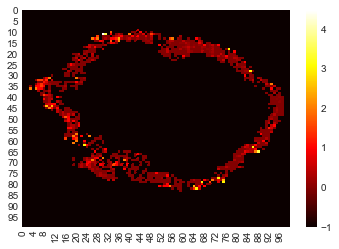

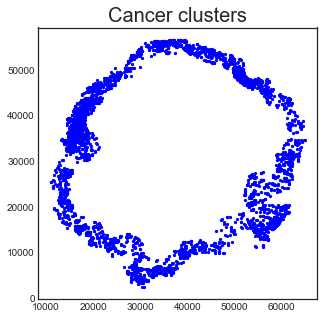

CD3 shape: (50310, 7)
CD8 shape: (69512, 7)
Clusters.shape: (3632, 7)
x.shape: (407520, 7) 


Code: 0691


100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


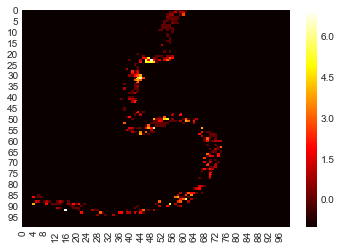

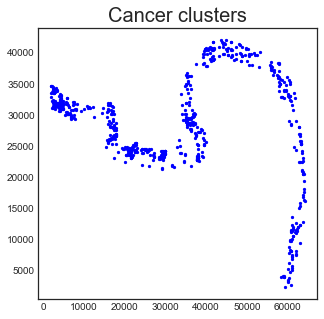

CD3 shape: (106941, 7)
CD8 shape: (87707, 7)
Clusters.shape: (674, 7)
x.shape: (407520, 7) 


Code: 0692


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


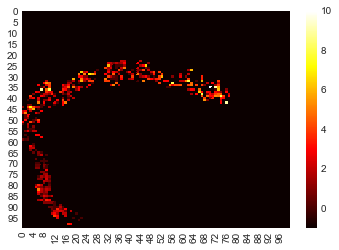

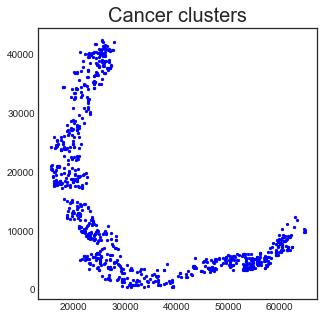

CD3 shape: (294324, 7)
CD8 shape: (414551, 7)
Clusters.shape: (825, 7)
x.shape: (407520, 7) 


Code: 0693


100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


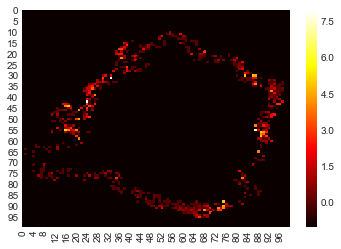

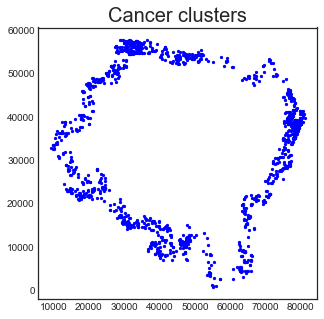

CD3 shape: (124983, 7)
CD8 shape: (137487, 7)
Clusters.shape: (1364, 7)
x.shape: (407520, 7) 


Code: 0694


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


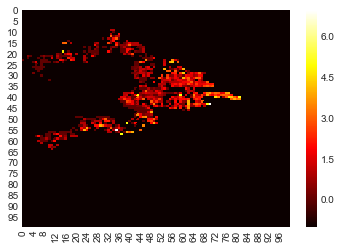

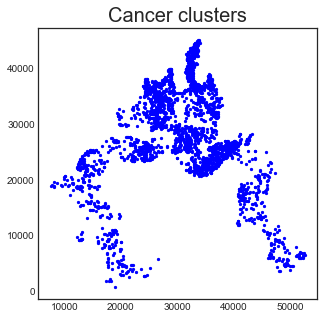

CD3 shape: (173990, 7)
CD8 shape: (46697, 7)
Clusters.shape: (2788, 7)
x.shape: (407520, 7) 


Code: 0695


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


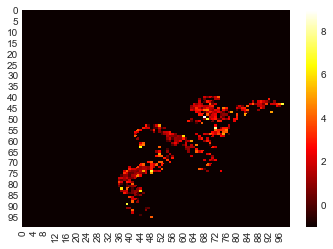

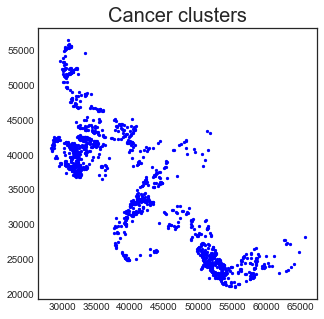

CD3 shape: (289999, 7)
CD8 shape: (107356, 7)
Clusters.shape: (1261, 7)
x.shape: (407520, 7) 


Code: 0696


100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


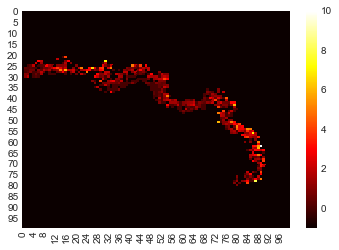

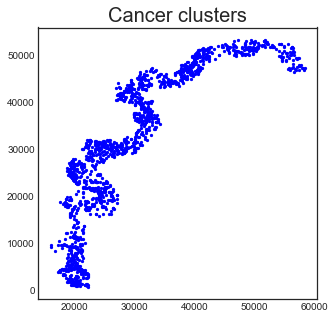

CD3 shape: (194152, 7)
CD8 shape: (100168, 7)
Clusters.shape: (1626, 7)
x.shape: (407520, 7) 


Code: 0697


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


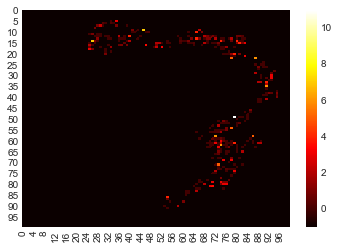

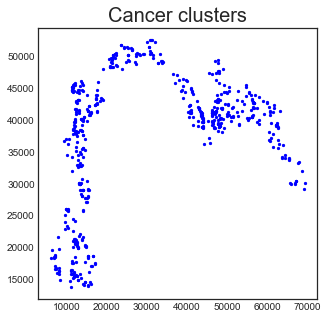

CD3 shape: (239915, 7)
CD8 shape: (393695, 7)
Clusters.shape: (593, 7)
x.shape: (407520, 7) 


Code: 0698


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


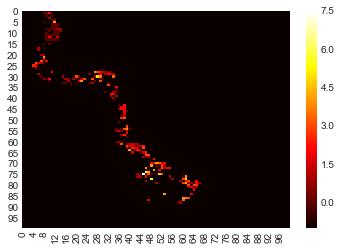

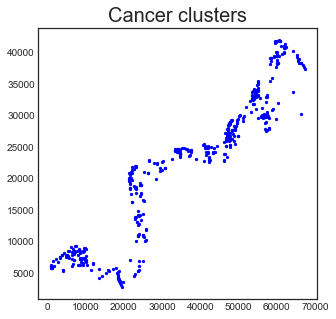

CD3 shape: (86917, 7)
CD8 shape: (449956, 7)
Clusters.shape: (475, 7)
x.shape: (407520, 7) 


Code: 0699


100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


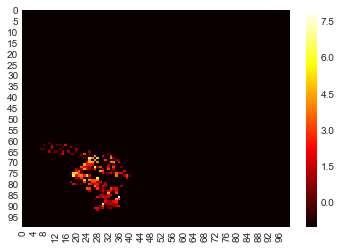

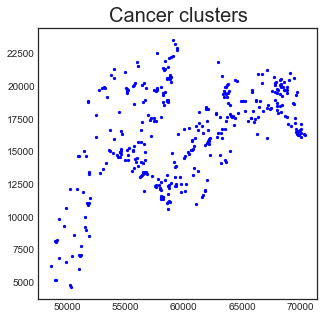

CD3 shape: (115644, 7)
CD8 shape: (34249, 7)
Clusters.shape: (375, 7)
x.shape: (407520, 7) 


Code: 0700


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


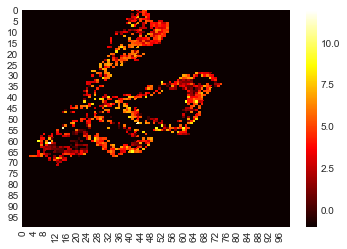

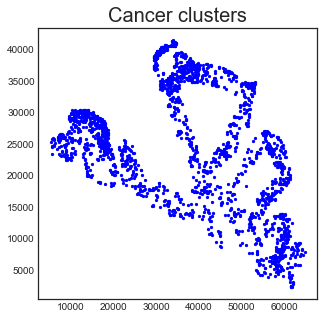

CD3 shape: (353292, 7)
CD8 shape: (290145, 7)
Clusters.shape: (2222, 7)
x.shape: (407520, 7) 


Code: 0701


100%|██████████| 100/100 [00:03<00:00, 29.12it/s]


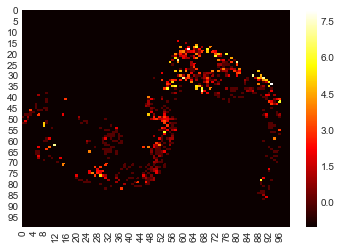

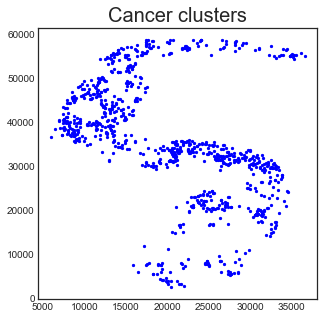

CD3 shape: (87239, 7)
CD8 shape: (25272, 7)
Clusters.shape: (935, 7)
x.shape: (407520, 7) 


Code: 0702


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


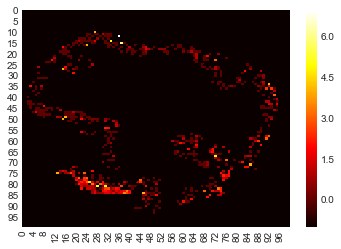

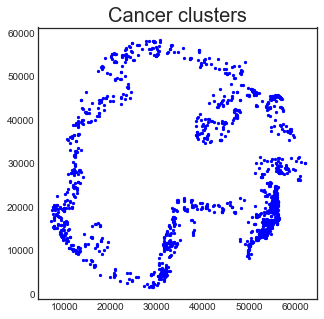

CD3 shape: (152401, 7)
CD8 shape: (51321, 7)
Clusters.shape: (1473, 7)
x.shape: (407520, 7) 


Code: 0703


100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


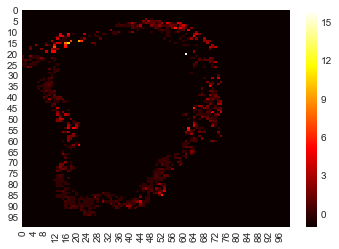

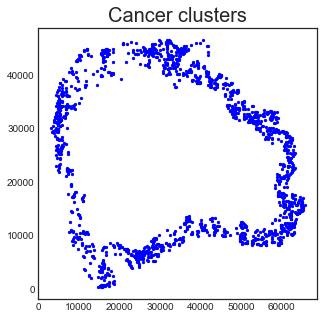

CD3 shape: (278863, 7)
CD8 shape: (126948, 7)
Clusters.shape: (1709, 7)
x.shape: (407520, 7) 


Code: 0704


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


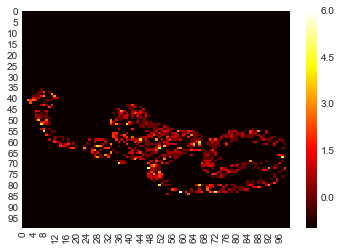

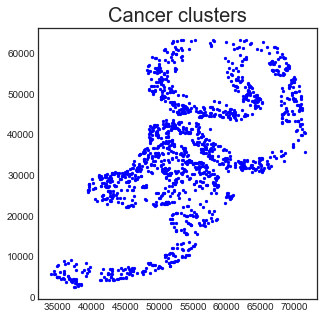

CD3 shape: (188772, 7)
CD8 shape: (151390, 7)
Clusters.shape: (1535, 7)
x.shape: (407520, 7) 


Code: 0706


100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


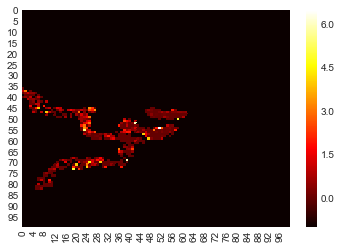

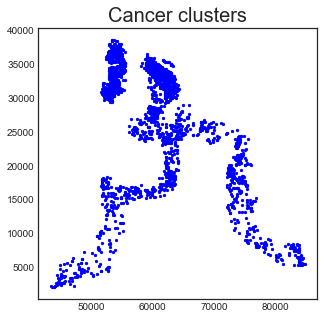

CD3 shape: (177596, 7)
CD8 shape: (39783, 7)
Clusters.shape: (2237, 7)
x.shape: (407520, 7) 


Code: 0707


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


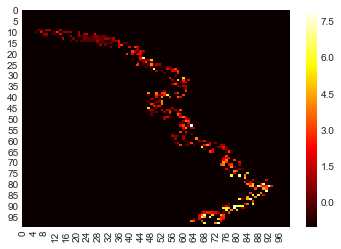

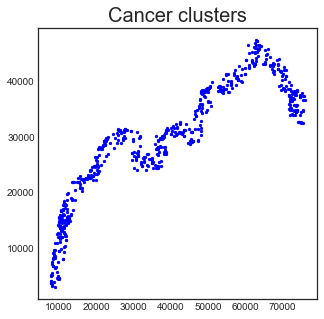

CD3 shape: (240437, 7)
CD8 shape: (225142, 7)
Clusters.shape: (656, 7)
x.shape: (407520, 7) 


Code: 0708


100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


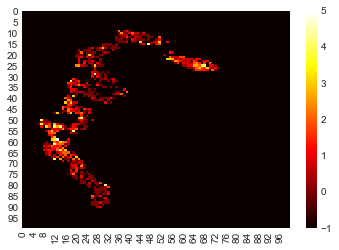

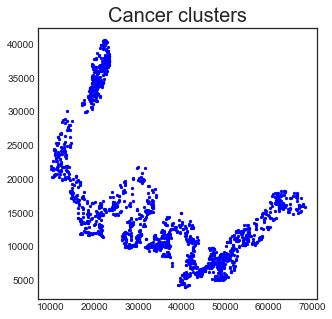

CD3 shape: (82579, 7)
CD8 shape: (37795, 7)
Clusters.shape: (1621, 7)
x.shape: (407520, 7) 


Code: 0709


100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


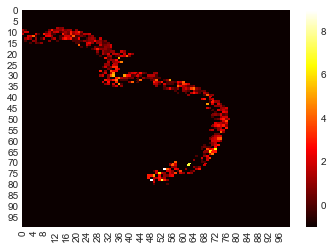

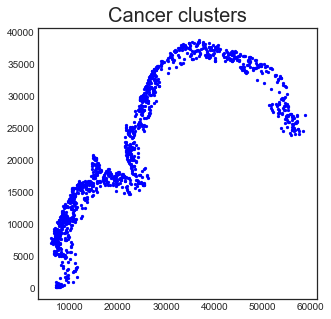

CD3 shape: (229736, 7)
CD8 shape: (71281, 7)
Clusters.shape: (1359, 7)
x.shape: (407520, 7) 


Code: 0710


100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


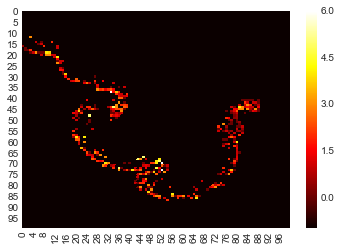

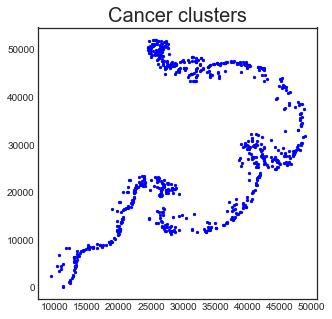

CD3 shape: (173816, 7)
CD8 shape: (74776, 7)
Clusters.shape: (778, 7)
x.shape: (407520, 7) 


Code: 0711


100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


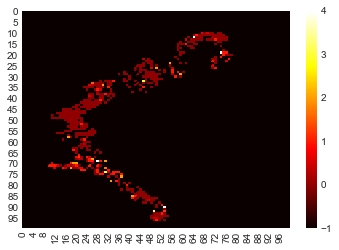

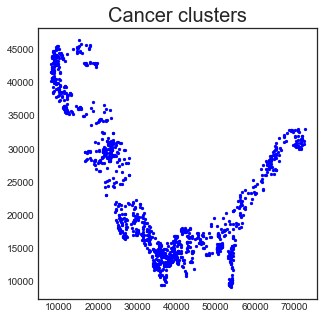

CD3 shape: (96120, 7)
CD8 shape: (21389, 7)
Clusters.shape: (1305, 7)
x.shape: (407520, 7) 


Code: 0712


100%|██████████| 100/100 [00:02<00:00, 45.83it/s]


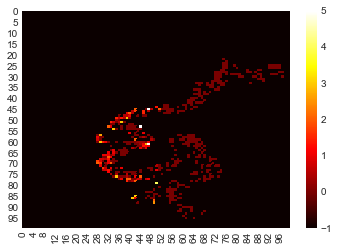

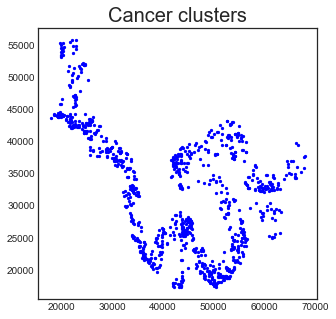

CD3 shape: (37689, 7)
CD8 shape: (29428, 7)
Clusters.shape: (1026, 7)
x.shape: (407520, 7) 


Code: 0713


100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


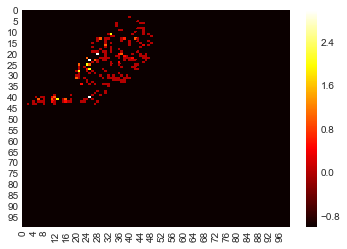

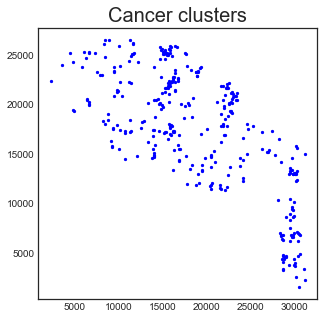

CD3 shape: (83675, 7)
CD8 shape: (25060, 7)
Clusters.shape: (350, 7)
x.shape: (407520, 7) 


Code: 0714


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


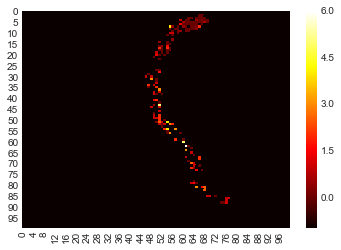

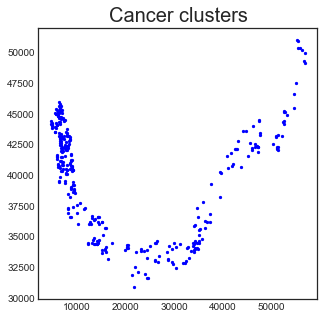

CD3 shape: (199176, 7)
CD8 shape: (137663, 7)
Clusters.shape: (346, 7)
x.shape: (407520, 7) 


Code: 0715


100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


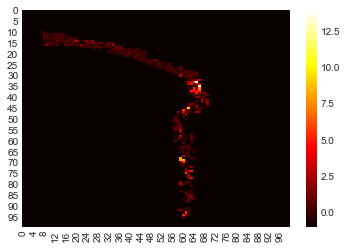

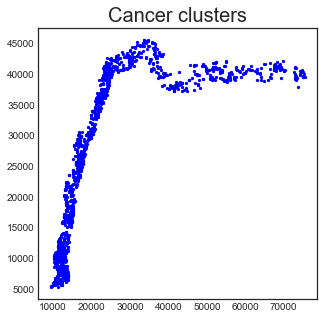

CD3 shape: (103029, 7)
CD8 shape: (196305, 7)
Clusters.shape: (1331, 7)
x.shape: (407520, 7) 


Code: 0716


100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


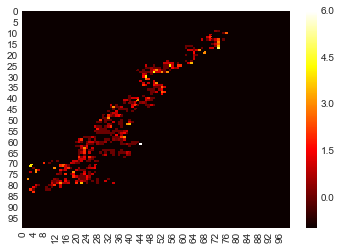

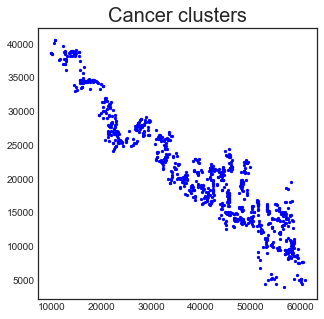

CD3 shape: (108891, 7)
CD8 shape: (39194, 7)
Clusters.shape: (899, 7)
x.shape: (407520, 7) 


Code: 0717


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


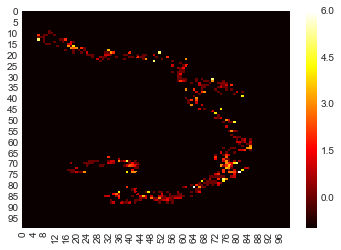

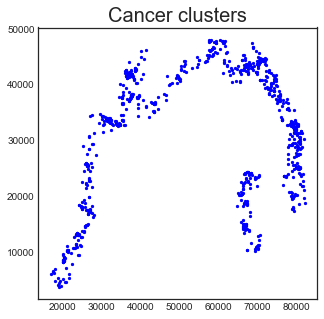

CD3 shape: (180638, 7)
CD8 shape: (148462, 7)
Clusters.shape: (819, 7)
x.shape: (407520, 7) 


Code: 0719


100%|██████████| 100/100 [00:02<00:00, 47.74it/s]


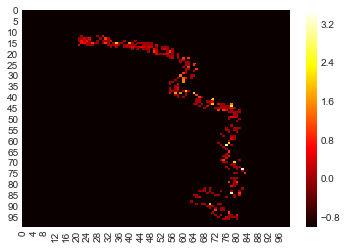

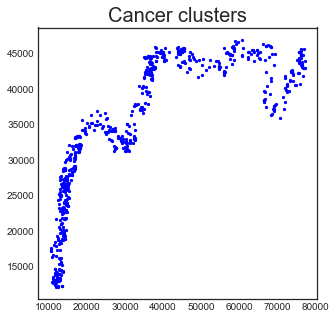

CD3 shape: (33091, 7)
CD8 shape: (32653, 7)
Clusters.shape: (682, 7)
x.shape: (407520, 7) 


Code: 0720


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


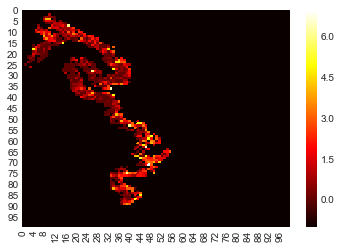

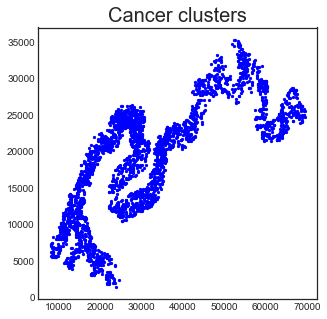

CD3 shape: (266159, 7)
CD8 shape: (78280, 7)
Clusters.shape: (3156, 7)
x.shape: (407520, 7) 


Code: 0721


100%|██████████| 100/100 [00:07<00:00, 14.27it/s]


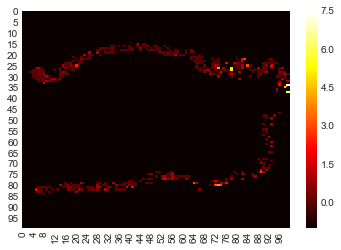

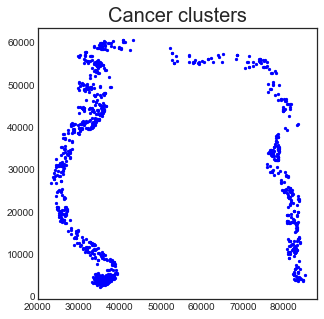

CD3 shape: (155669, 7)
CD8 shape: (38601, 7)
Clusters.shape: (1071, 7)
x.shape: (407520, 7) 


Code: 0722


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


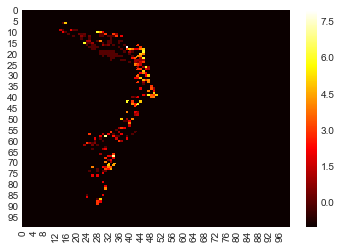

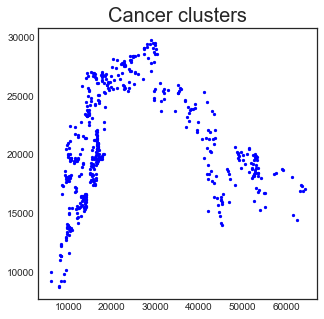

CD3 shape: (182945, 7)
CD8 shape: (158284, 7)
Clusters.shape: (511, 7)
x.shape: (407520, 7) 


Code: 0723


100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


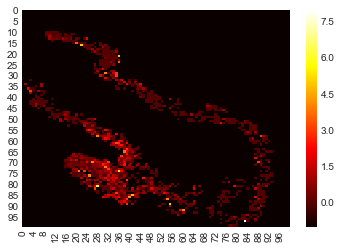

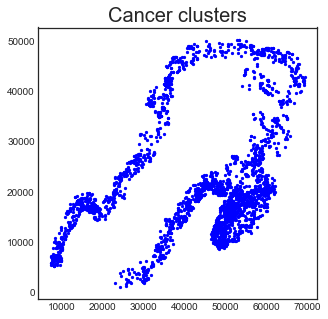

CD3 shape: (94449, 7)
CD8 shape: (22101, 7)
Clusters.shape: (2824, 7)
x.shape: (407520, 7) 


Code: 0724


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


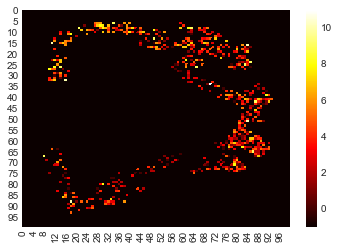

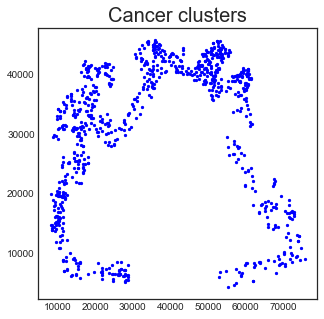

CD3 shape: (451740, 7)
CD8 shape: (125381, 7)
Clusters.shape: (899, 7)
x.shape: (407520, 7) 


Code: 0725


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


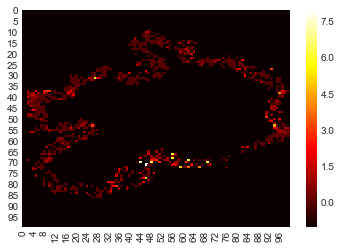

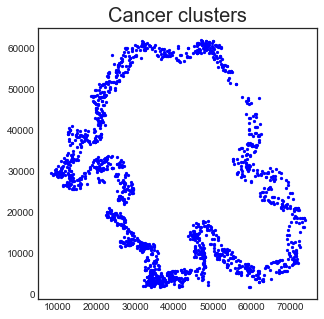

CD3 shape: (127003, 7)
CD8 shape: (183741, 7)
Clusters.shape: (1763, 7)
x.shape: (407520, 7) 


Code: 0727


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


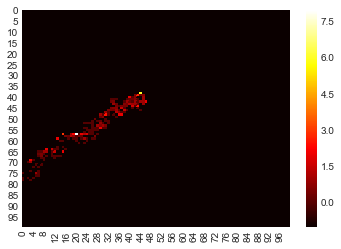

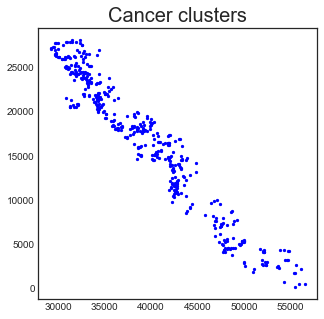

CD3 shape: (412124, 7)
CD8 shape: (55327, 7)
Clusters.shape: (474, 7)
x.shape: (407520, 7) 


Code: 0728


100%|██████████| 100/100 [00:05<00:00, 19.62it/s]


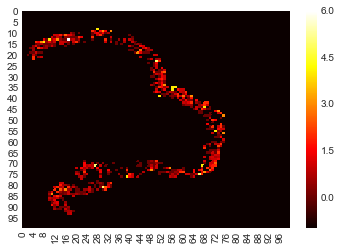

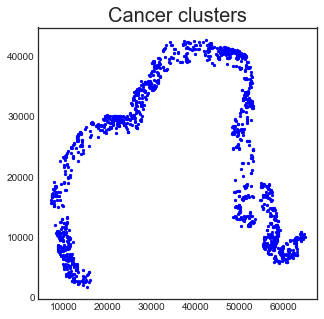

CD3 shape: (112388, 7)
CD8 shape: (40069, 7)
Clusters.shape: (1406, 7)
x.shape: (407520, 7) 


Code: 0729


100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


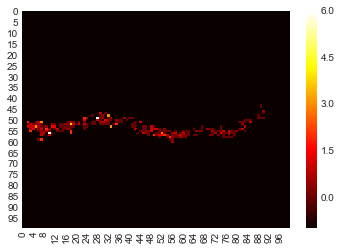

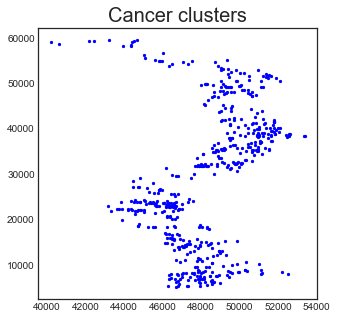

CD3 shape: (141542, 7)
CD8 shape: (22273, 7)
Clusters.shape: (535, 7)
x.shape: (407520, 7) 


Code: 0730


100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


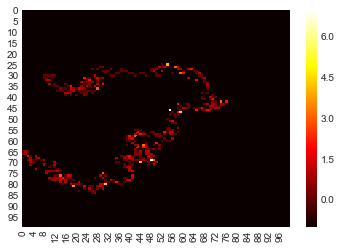

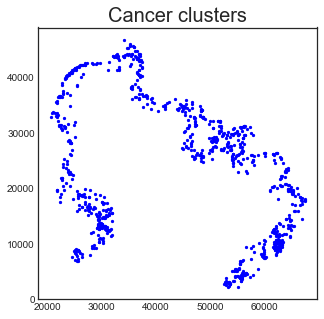

CD3 shape: (92452, 7)
CD8 shape: (213348, 7)
Clusters.shape: (929, 7)
x.shape: (407520, 7) 


Code: 0731


100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


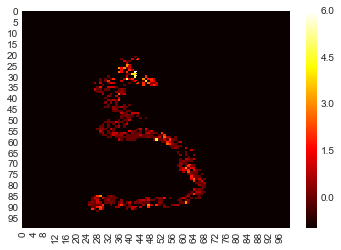

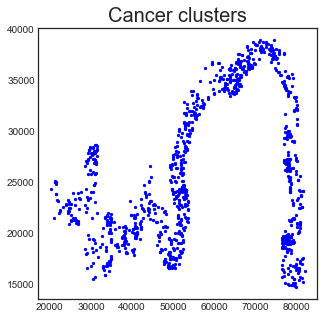

CD3 shape: (115600, 7)
CD8 shape: (73984, 7)
Clusters.shape: (1082, 7)
x.shape: (407520, 7) 


Code: 0732


100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


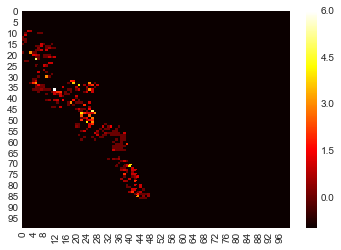

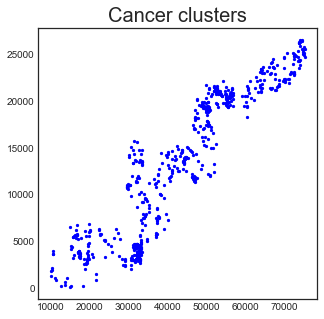

CD3 shape: (84515, 7)
CD8 shape: (108935, 7)
Clusters.shape: (660, 7)
x.shape: (407520, 7) 


Code: 0733


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


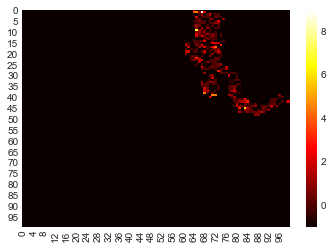

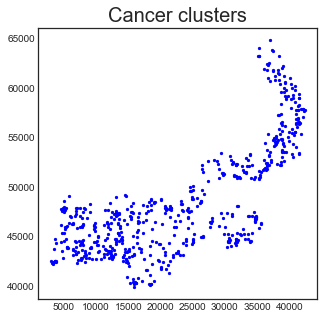

CD3 shape: (338001, 7)
CD8 shape: (42719, 7)
Clusters.shape: (636, 7)
x.shape: (407520, 7) 


Code: 0734


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


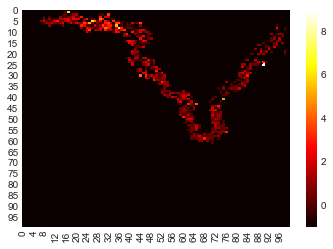

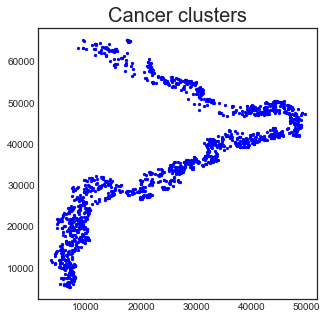

CD3 shape: (381235, 7)
CD8 shape: (35873, 7)
Clusters.shape: (1526, 7)
x.shape: (407520, 7) 


Code: 0735


100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


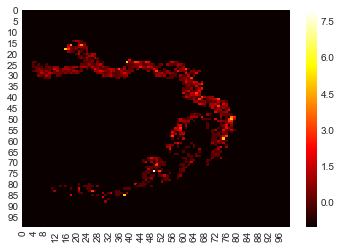

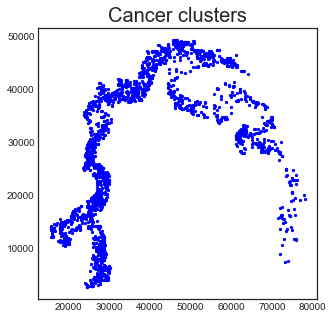

CD3 shape: (183722, 7)
CD8 shape: (78844, 7)
Clusters.shape: (2190, 7)
x.shape: (407520, 7) 


Code: 0736


100%|██████████| 100/100 [00:01<00:00, 87.06it/s]


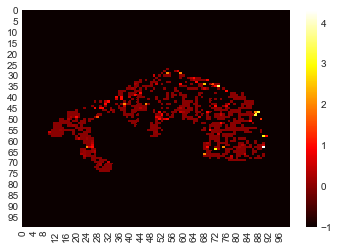

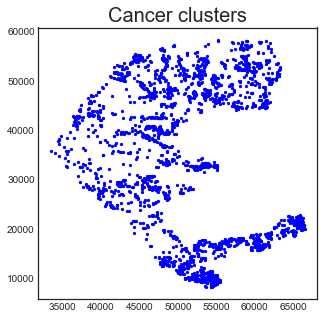

CD3 shape: (20970, 7)
CD8 shape: (3165, 7)
Clusters.shape: (2329, 7)
x.shape: (407520, 7) 


Code: 0737


100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


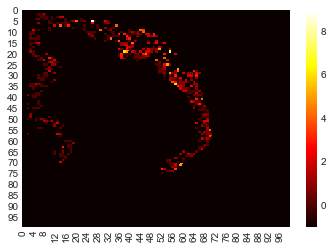

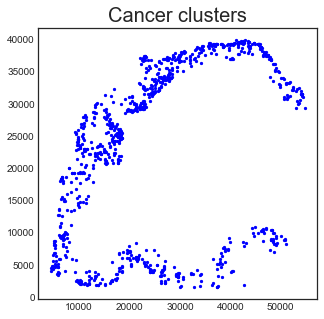

CD3 shape: (160211, 7)
CD8 shape: (31837, 7)
Clusters.shape: (966, 7)
x.shape: (407520, 7) 


Code: 0738


100%|██████████| 100/100 [00:02<00:00, 37.95it/s]


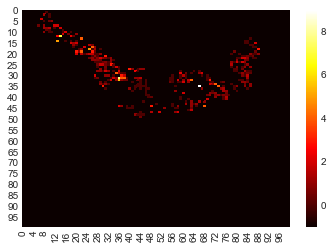

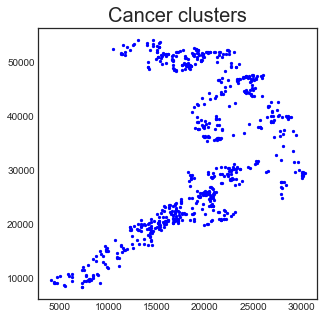

CD3 shape: (72781, 7)
CD8 shape: (18313, 7)
Clusters.shape: (684, 7)
x.shape: (407520, 7) 


Code: 0739


100%|██████████| 100/100 [00:04<00:00, 22.97it/s]


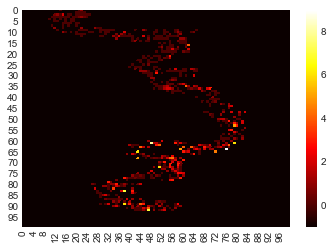

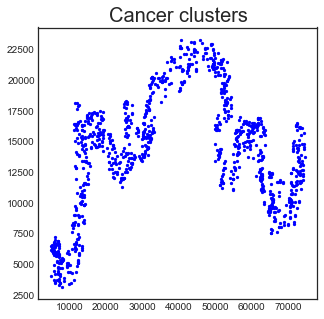

CD3 shape: (65089, 7)
CD8 shape: (66732, 7)
Clusters.shape: (1104, 7)
x.shape: (407520, 7) 


Code: 0740


100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


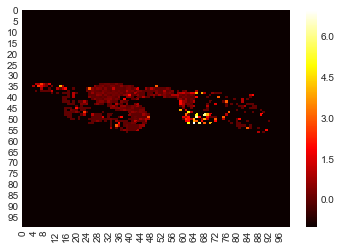

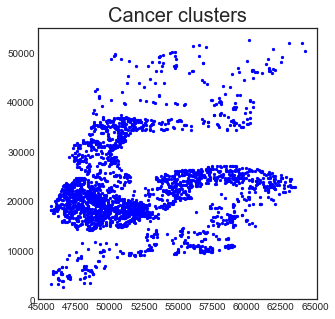

CD3 shape: (188401, 7)
CD8 shape: (27451, 7)
Clusters.shape: (2428, 7)
x.shape: (407520, 7) 


Code: 0741


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


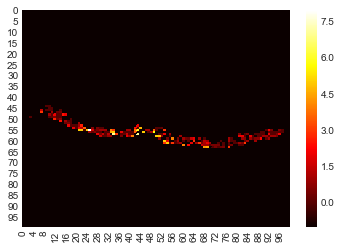

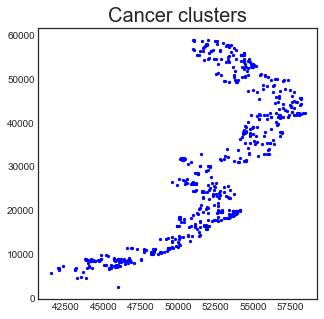

CD3 shape: (393180, 7)
CD8 shape: (129803, 7)
Clusters.shape: (572, 7)
x.shape: (407520, 7) 


Code: 0742


100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


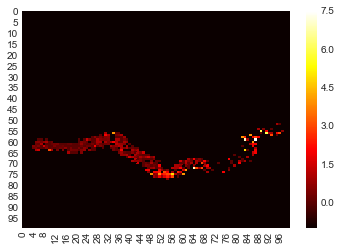

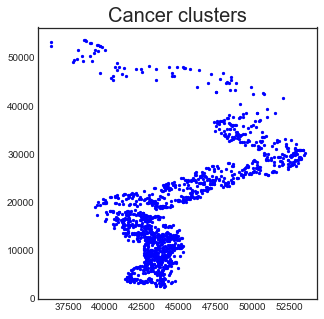

CD3 shape: (139637, 7)
CD8 shape: (104684, 7)
Clusters.shape: (1286, 7)
x.shape: (407520, 7) 


Code: 0744


100%|██████████| 100/100 [00:02<00:00, 49.55it/s]


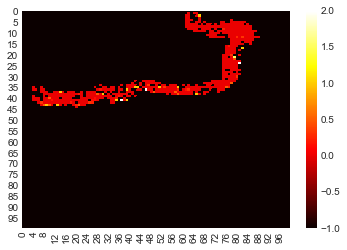

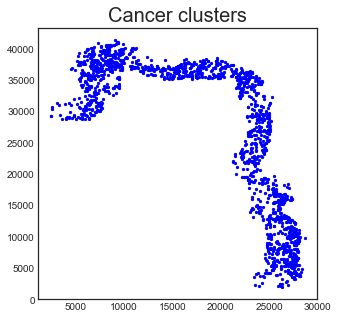

CD3 shape: (46716, 7)
CD8 shape: (15620, 7)
Clusters.shape: (1680, 7)
x.shape: (407520, 7) 


Code: 0745


100%|██████████| 100/100 [00:02<00:00, 38.81it/s]


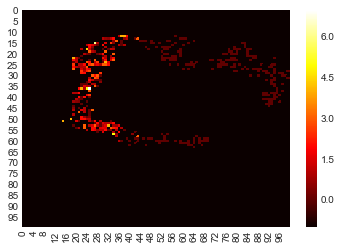

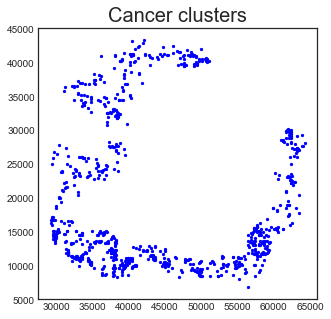

CD3 shape: (68622, 7)
CD8 shape: (21492, 7)
Clusters.shape: (846, 7)
x.shape: (407520, 7) 


Code: 0746


100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


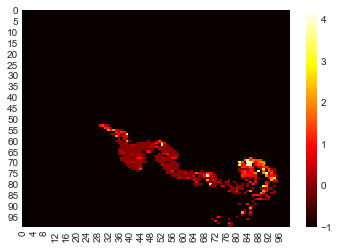

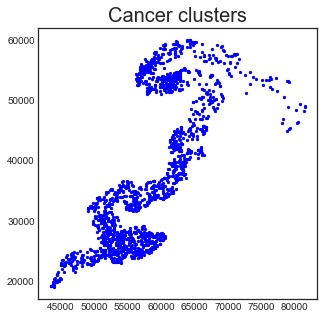

CD3 shape: (177640, 7)
CD8 shape: (27112, 7)
Clusters.shape: (1709, 7)
x.shape: (407520, 7) 


Code: 0747


100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


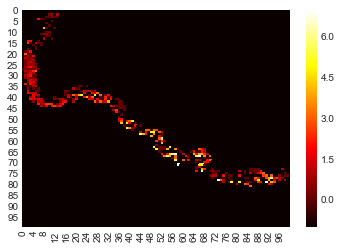

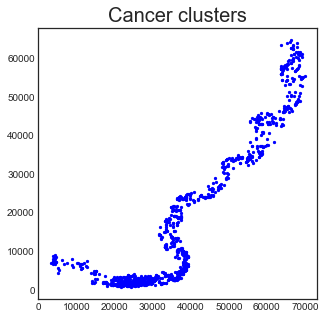

CD3 shape: (114172, 7)
CD8 shape: (118683, 7)
Clusters.shape: (1177, 7)
x.shape: (407520, 7) 


Code: 0748


100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


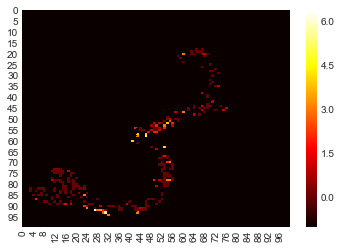

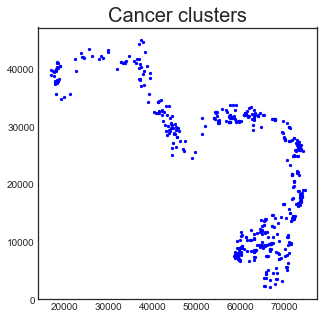

CD3 shape: (126691, 7)
CD8 shape: (58046, 7)
Clusters.shape: (508, 7)
x.shape: (407520, 7) 


Code: 0749


100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


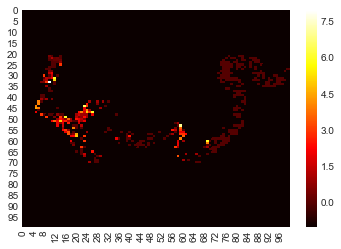

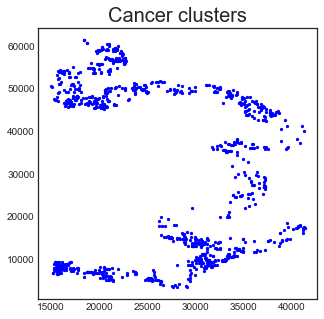

CD3 shape: (104298, 7)
CD8 shape: (77727, 7)
Clusters.shape: (977, 7)
x.shape: (407520, 7) 


Code: 0750


100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


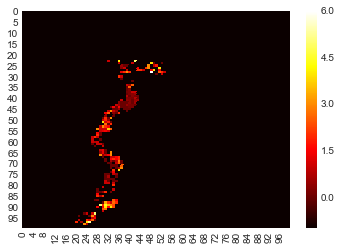

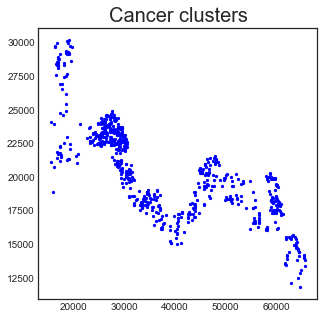

CD3 shape: (78151, 7)
CD8 shape: (100389, 7)
Clusters.shape: (668, 7)
x.shape: (407520, 7) 


Code: 0751


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


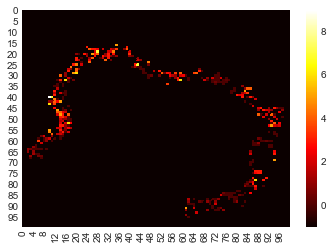

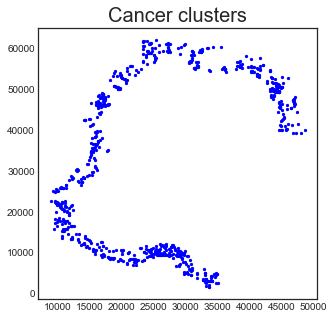

CD3 shape: (224066, 7)
CD8 shape: (49679, 7)
Clusters.shape: (788, 7)
x.shape: (407520, 7) 


Code: 0752


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


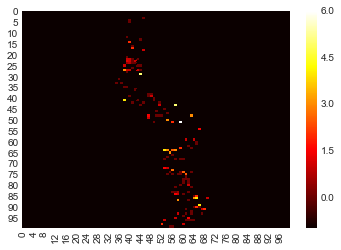

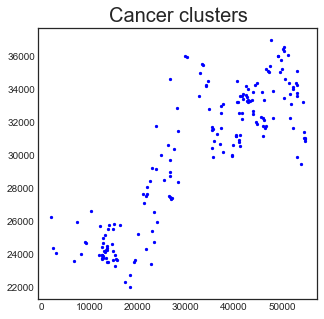

CD3 shape: (122915, 7)
CD8 shape: (110567, 7)
Clusters.shape: (184, 7)
x.shape: (407520, 7) 


Code: 0753


100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


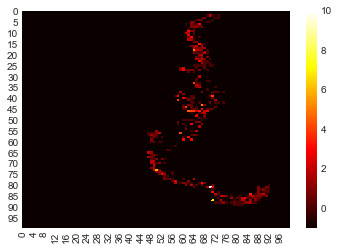

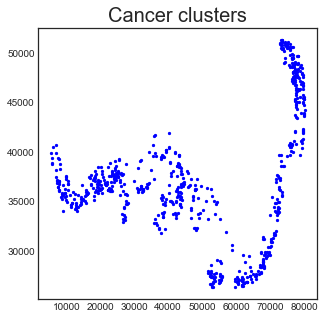

CD3 shape: (125022, 7)
CD8 shape: (36434, 7)
Clusters.shape: (726, 7)
x.shape: (407520, 7) 


Code: 0754


100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


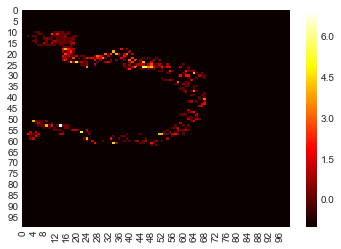

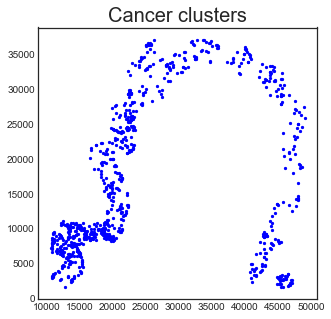

CD3 shape: (160354, 7)
CD8 shape: (102512, 7)
Clusters.shape: (877, 7)
x.shape: (407520, 7) 


Code: 0755


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


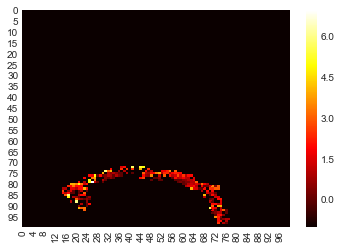

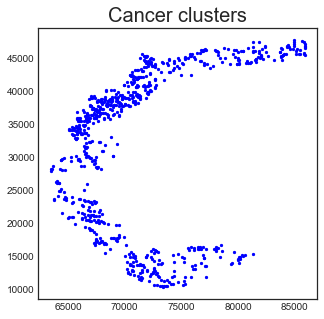

CD3 shape: (266047, 7)
CD8 shape: (100090, 7)
Clusters.shape: (800, 7)
x.shape: (407520, 7) 


Code: 0757


100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


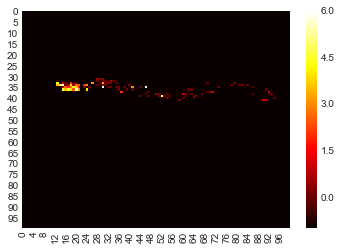

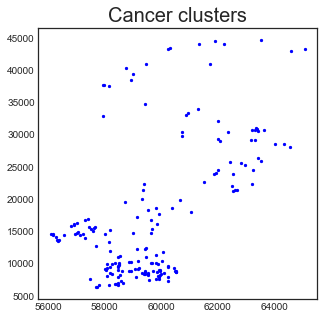

CD3 shape: (188412, 7)
CD8 shape: (52166, 7)
Clusters.shape: (182, 7)
x.shape: (407520, 7) 


Code: 0758


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


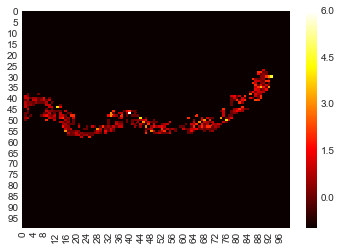

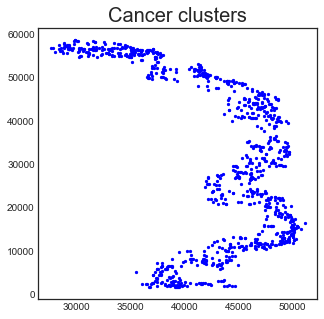

CD3 shape: (195062, 7)
CD8 shape: (122595, 7)
Clusters.shape: (981, 7)
x.shape: (407520, 7) 


Code: 0759


100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


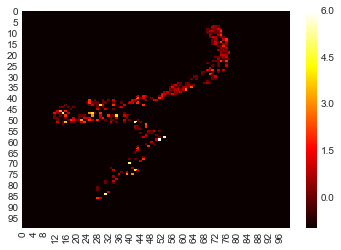

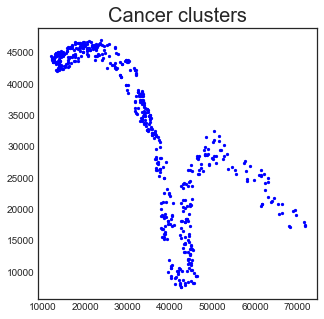

CD3 shape: (87299, 7)
CD8 shape: (96195, 7)
Clusters.shape: (573, 7)
x.shape: (407520, 7) 


Code: 0760


100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


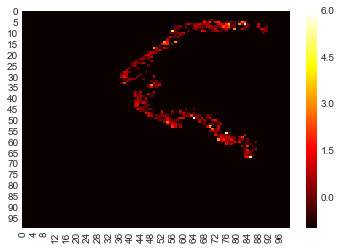

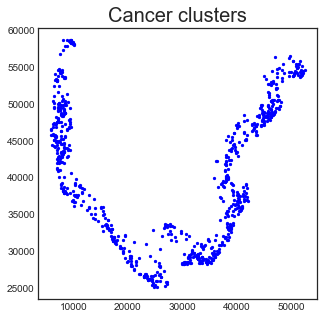

CD3 shape: (197334, 7)
CD8 shape: (24139, 7)
Clusters.shape: (828, 7)
x.shape: (407520, 7) 


Code: 0761


100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


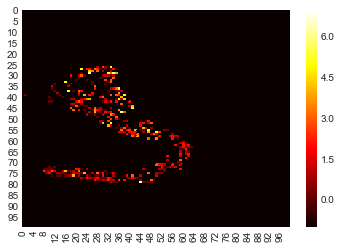

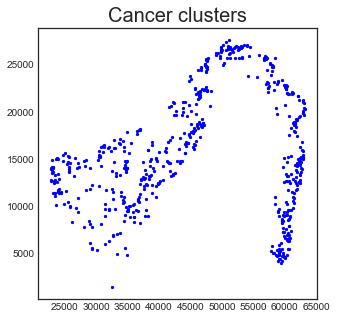

CD3 shape: (214956, 7)
CD8 shape: (24165, 7)
Clusters.shape: (612, 7)
x.shape: (407520, 7) 


Code: 0762


100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


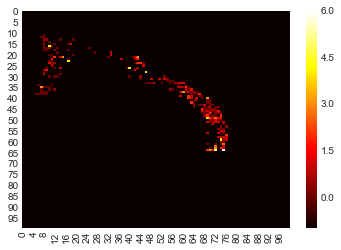

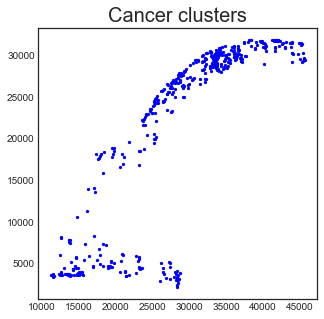

CD3 shape: (94319, 7)
CD8 shape: (119490, 7)
Clusters.shape: (459, 7)
x.shape: (407520, 7) 


Code: 0763


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


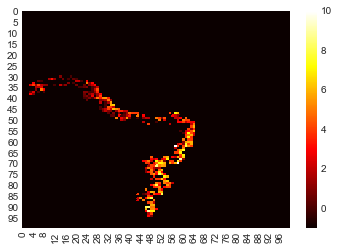

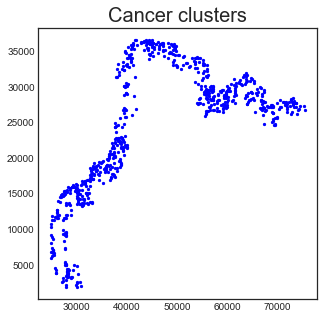

CD3 shape: (530029, 7)
CD8 shape: (205948, 7)
Clusters.shape: (751, 7)
x.shape: (407520, 7) 


Code: 0764


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


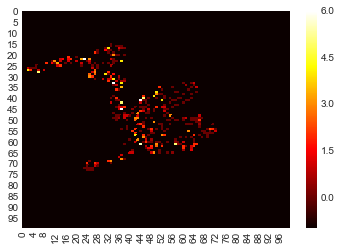

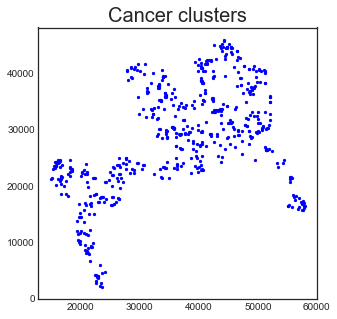

CD3 shape: (241197, 7)
CD8 shape: (77702, 7)
Clusters.shape: (587, 7)
x.shape: (407520, 7) 


Code: 0765


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


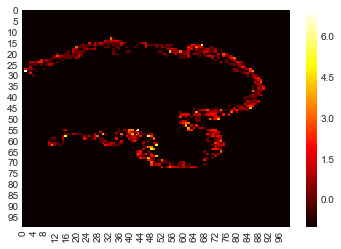

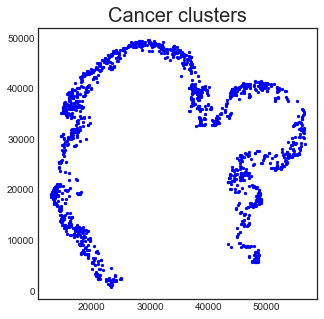

CD3 shape: (187815, 7)
CD8 shape: (31504, 7)
Clusters.shape: (1468, 7)
x.shape: (407520, 7) 


Code: 0767


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


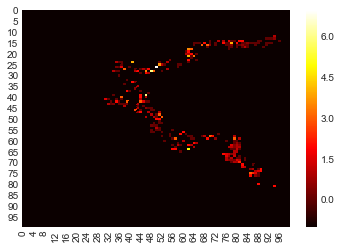

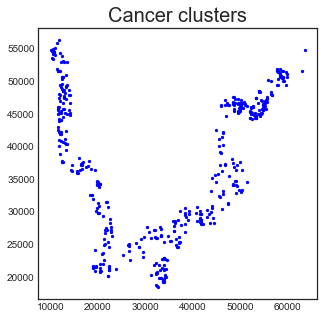

CD3 shape: (161337, 7)
CD8 shape: (55621, 7)
Clusters.shape: (501, 7)
x.shape: (407520, 7) 


Code: 0768


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


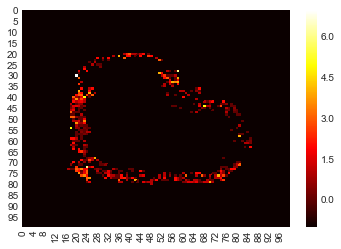

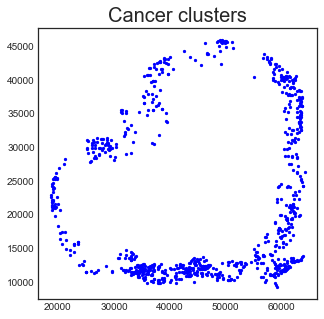

CD3 shape: (165265, 7)
CD8 shape: (251818, 7)
Clusters.shape: (860, 7)
x.shape: (407520, 7) 


Code: 0769


100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


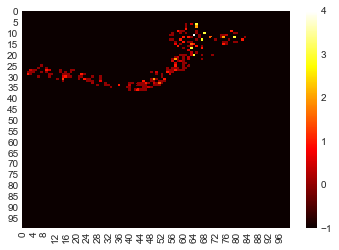

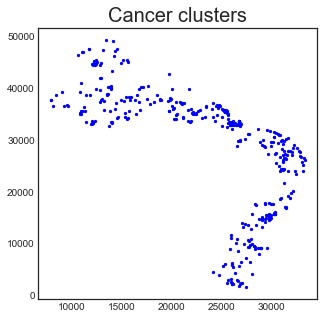

CD3 shape: (192991, 7)
CD8 shape: (12956, 7)
Clusters.shape: (393, 7)
x.shape: (407520, 7) 


Code: 0770


100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


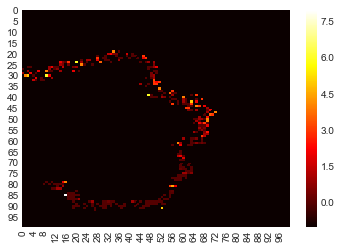

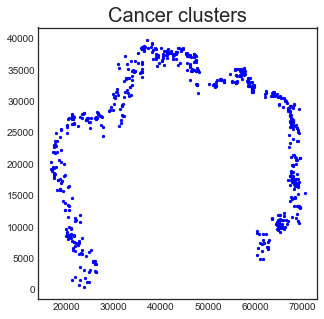

CD3 shape: (163406, 7)
CD8 shape: (78392, 7)
Clusters.shape: (636, 7)
x.shape: (407520, 7) 


Code: 0772


100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


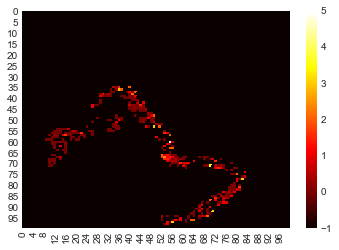

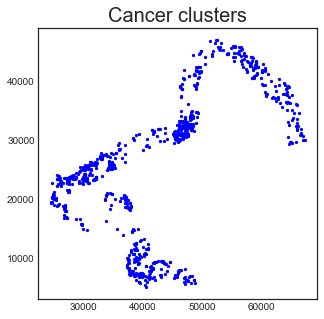

CD3 shape: (155864, 7)
CD8 shape: (44210, 7)
Clusters.shape: (811, 7)
x.shape: (407520, 7) 


Code: 0774


100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


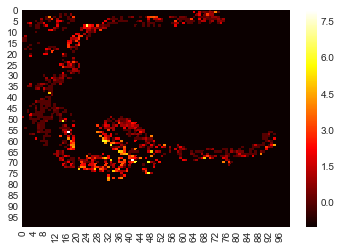

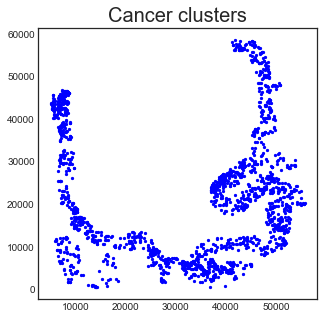

CD3 shape: (144242, 7)
CD8 shape: (69037, 7)
Clusters.shape: (1903, 7)
x.shape: (407520, 7) 


Code: 0775


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


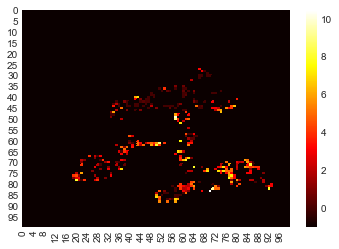

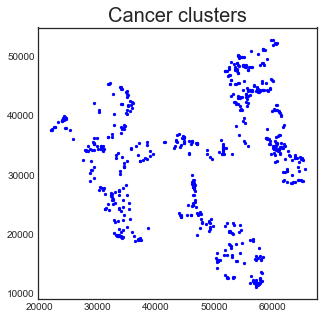

CD3 shape: (299961, 7)
CD8 shape: (140731, 7)
Clusters.shape: (623, 7)
x.shape: (407520, 7) 


Code: 0776


100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


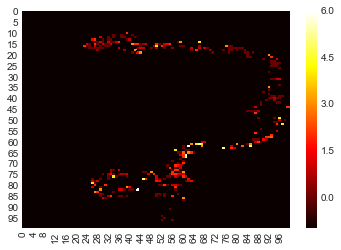

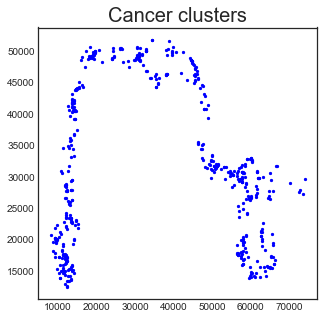

CD3 shape: (138276, 7)
CD8 shape: (109910, 7)
Clusters.shape: (527, 7)
x.shape: (407520, 7) 


Code: 0777


100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


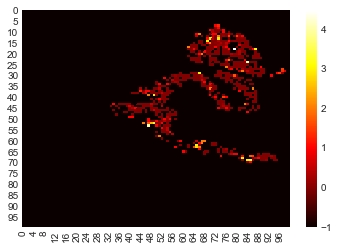

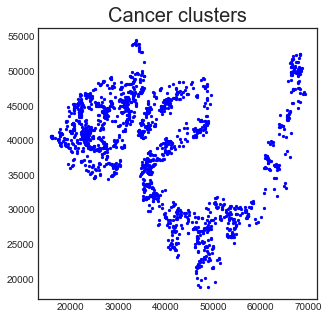

CD3 shape: (93901, 7)
CD8 shape: (14150, 7)
Clusters.shape: (1725, 7)
x.shape: (407520, 7) 


Code: 0778


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


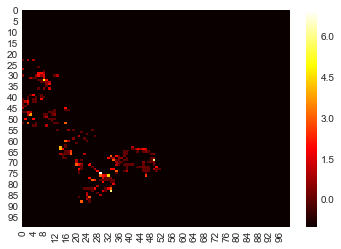

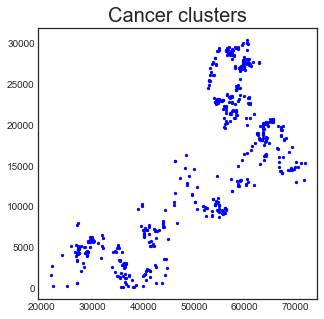

CD3 shape: (325578, 7)
CD8 shape: (42826, 7)
Clusters.shape: (522, 7)
x.shape: (407520, 7) 


Code: 0779


100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


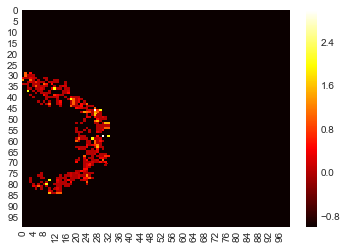

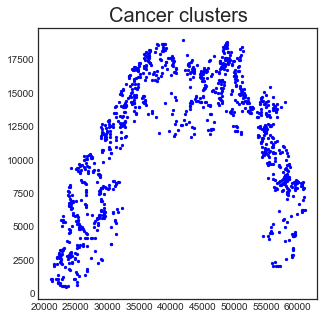

CD3 shape: (79434, 7)
CD8 shape: (27020, 7)
Clusters.shape: (1072, 7)
x.shape: (407520, 7) 


Code: 0780


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


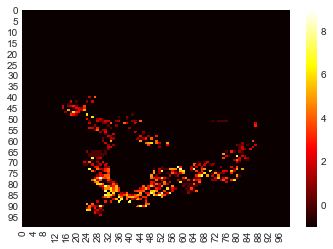

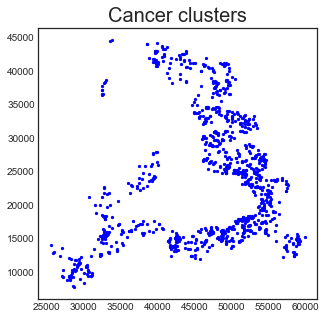

CD3 shape: (172850, 7)
CD8 shape: (208866, 7)
Clusters.shape: (1028, 7)
x.shape: (407520, 7) 


Code: 0781


100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


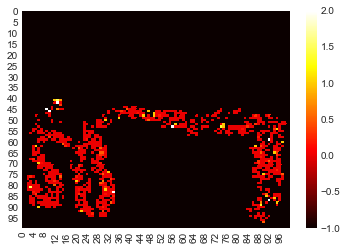

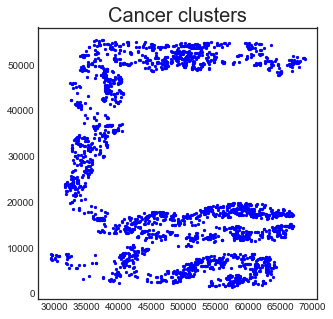

CD3 shape: (86504, 7)
CD8 shape: (15926, 7)
Clusters.shape: (2369, 7)
x.shape: (407520, 7) 


Code: 0782


100%|██████████| 100/100 [00:02<00:00, 37.55it/s]


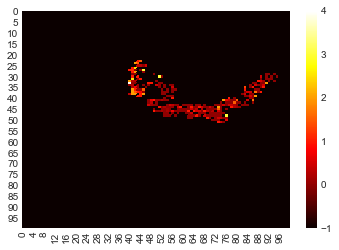

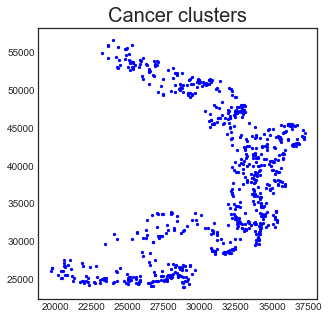

CD3 shape: (55806, 7)
CD8 shape: (16560, 7)
Clusters.shape: (716, 7)
x.shape: (407520, 7) 


Code: 0783


100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


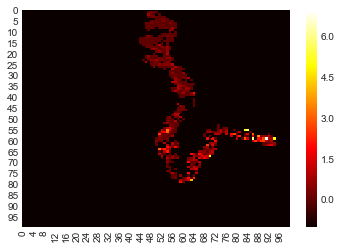

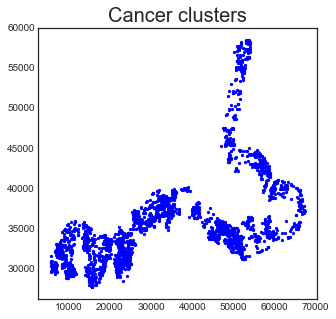

CD3 shape: (111806, 7)
CD8 shape: (39974, 7)
Clusters.shape: (2350, 7)
x.shape: (407520, 7) 


Code: 0784


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


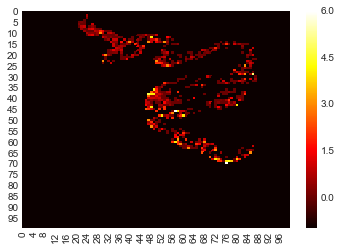

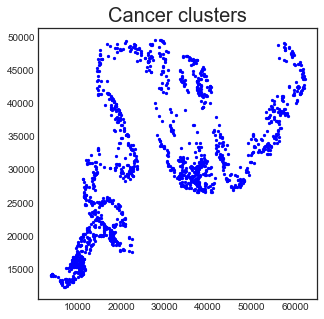

CD3 shape: (184408, 7)
CD8 shape: (91347, 7)
Clusters.shape: (1448, 7)
x.shape: (407520, 7) 


Code: 0785


100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


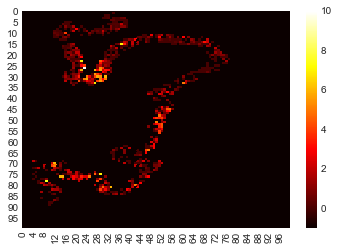

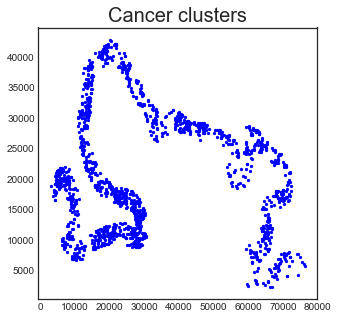

CD3 shape: (195110, 7)
CD8 shape: (77786, 7)
Clusters.shape: (1700, 7)
x.shape: (407520, 7) 


Code: 0786


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


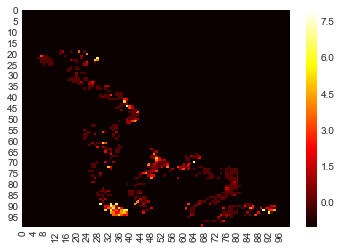

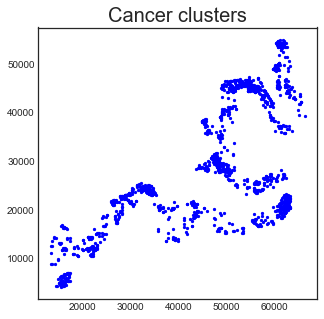

CD3 shape: (263913, 7)
CD8 shape: (222890, 7)
Clusters.shape: (1507, 7)
x.shape: (407520, 7) 


Code: 0787


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


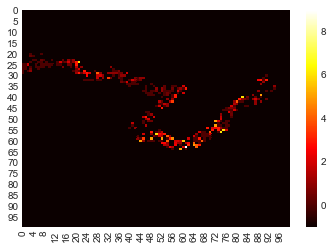

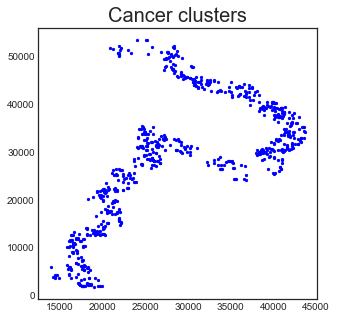

CD3 shape: (229185, 7)
CD8 shape: (83427, 7)
Clusters.shape: (731, 7)
x.shape: (407520, 7) 


Code: 0788


100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


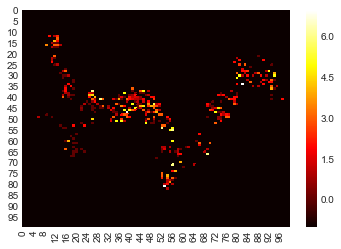

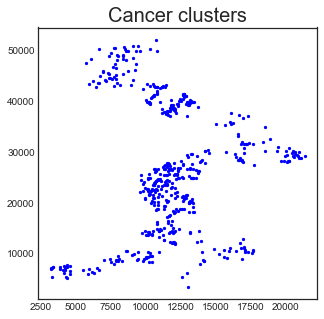

CD3 shape: (99804, 7)
CD8 shape: (20696, 7)
Clusters.shape: (540, 7)
x.shape: (407520, 7) 


Code: 0790


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


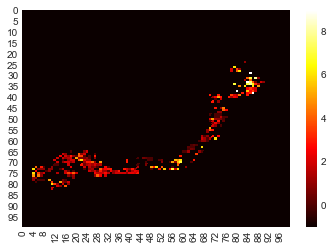

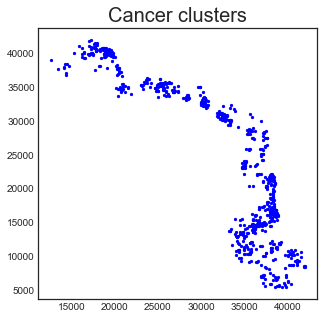

CD3 shape: (72359, 7)
CD8 shape: (365945, 7)
Clusters.shape: (722, 7)
x.shape: (407520, 7) 


Code: 0791


100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


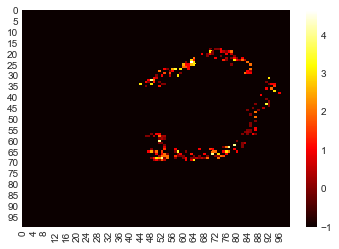

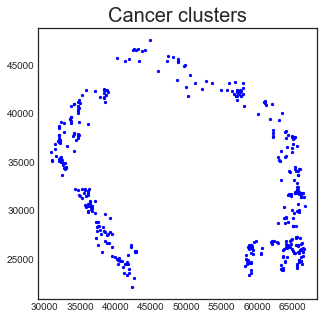

CD3 shape: (67059, 7)
CD8 shape: (39552, 7)
Clusters.shape: (395, 7)
x.shape: (407520, 7) 


Code: 0792


100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


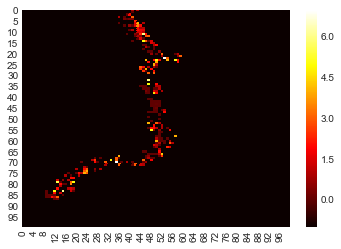

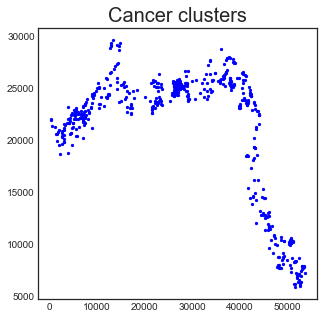

CD3 shape: (89714, 7)
CD8 shape: (81323, 7)
Clusters.shape: (565, 7)
x.shape: (407520, 7) 


Code: 0793


100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


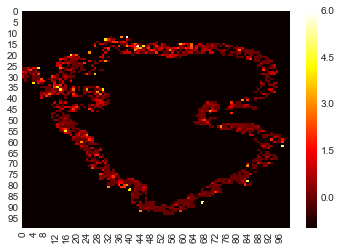

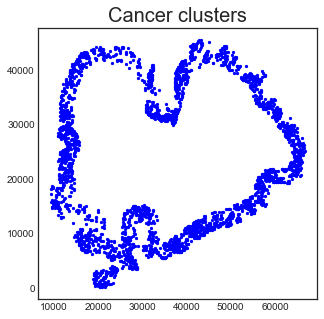

CD3 shape: (92291, 7)
CD8 shape: (25732, 7)
Clusters.shape: (3470, 7)
x.shape: (407520, 7) 


Code: 0795


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


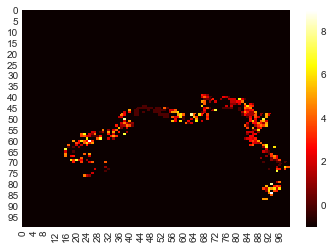

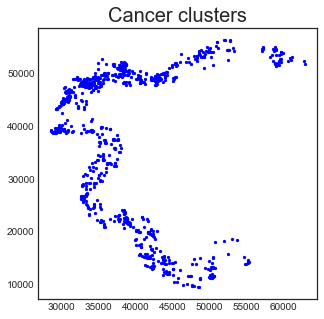

CD3 shape: (339044, 7)
CD8 shape: (156447, 7)
Clusters.shape: (832, 7)
x.shape: (407520, 7) 


Code: 0796


100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


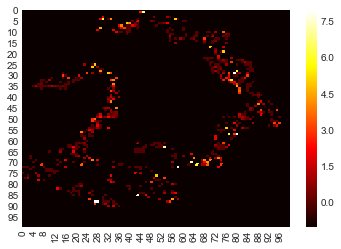

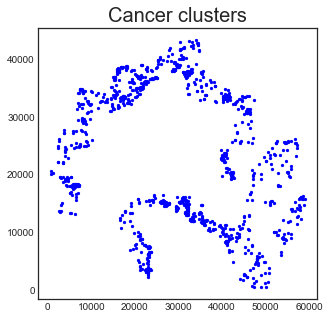

CD3 shape: (228766, 7)
CD8 shape: (84872, 7)
Clusters.shape: (1095, 7)
x.shape: (407520, 7) 


Code: 0797


100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


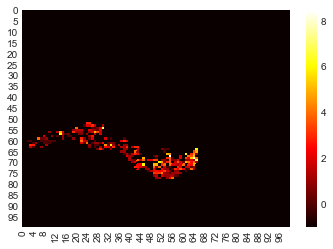

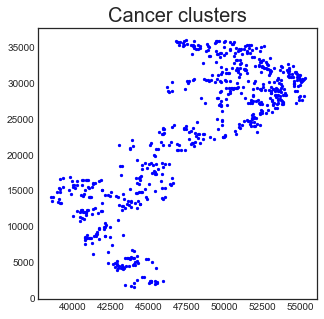

CD3 shape: (229358, 7)
CD8 shape: (163552, 7)
Clusters.shape: (656, 7)
x.shape: (407520, 7) 


Code: 0798


100%|██████████| 100/100 [00:07<00:00, 14.18it/s]


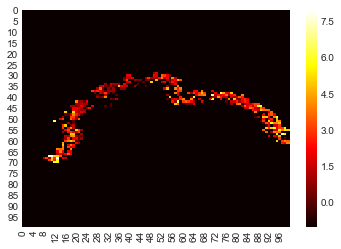

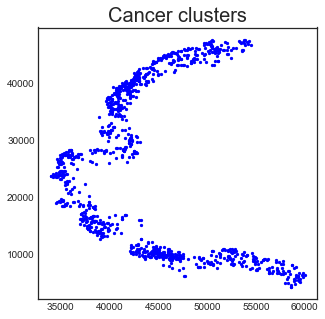

CD3 shape: (140599, 7)
CD8 shape: (71007, 7)
Clusters.shape: (1082, 7)
x.shape: (407520, 7) 


Code: 0799


100%|██████████| 100/100 [00:04<00:00, 20.86it/s]


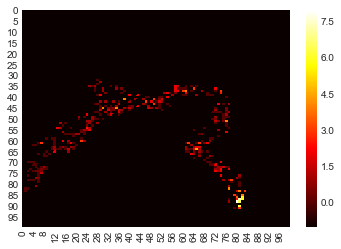

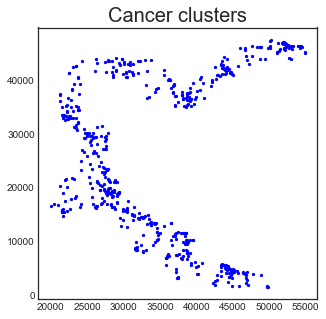

CD3 shape: (54620, 7)
CD8 shape: (100425, 7)
Clusters.shape: (578, 7)
x.shape: (407520, 7) 


Code: 0800


100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


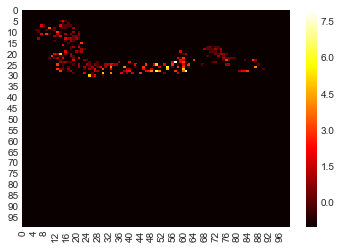

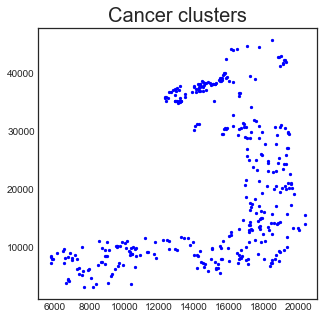

CD3 shape: (126460, 7)
CD8 shape: (131593, 7)
Clusters.shape: (367, 7)
x.shape: (407520, 7) 


Code: 0801


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


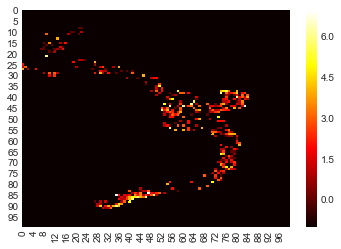

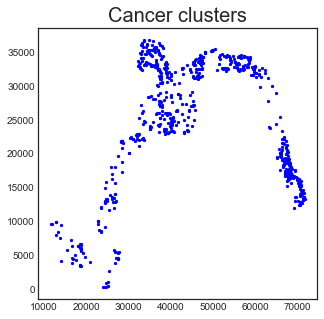

CD3 shape: (189484, 7)
CD8 shape: (534474, 7)
Clusters.shape: (680, 7)
x.shape: (407520, 7) 


Code: 0803


100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


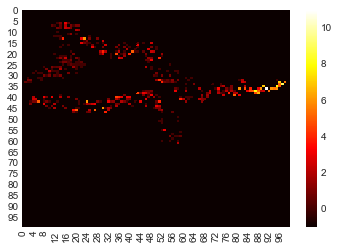

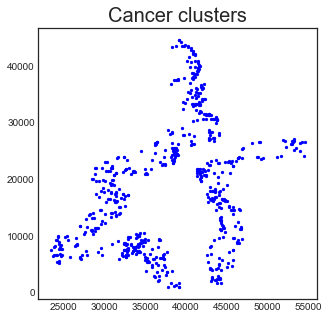

CD3 shape: (99238, 7)
CD8 shape: (169082, 7)
Clusters.shape: (665, 7)
x.shape: (407520, 7) 


Code: 0804


100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


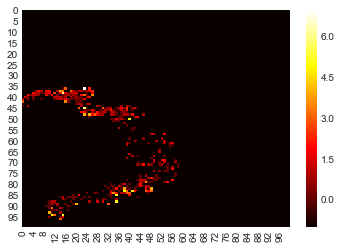

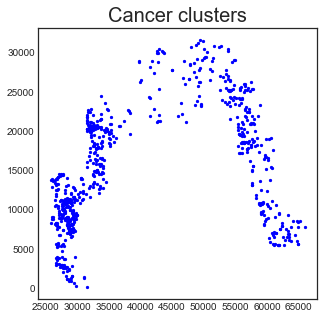

CD3 shape: (91702, 7)
CD8 shape: (45070, 7)
Clusters.shape: (755, 7)
x.shape: (407520, 7) 


Code: 0805


100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


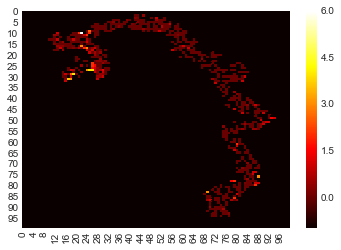

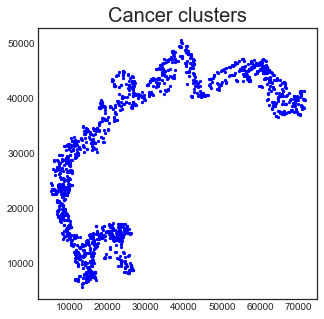

CD3 shape: (83884, 7)
CD8 shape: (182778, 7)
Clusters.shape: (1441, 7)
x.shape: (407520, 7) 


Code: 3300


100%|██████████| 100/100 [00:01<00:00, 51.08it/s]


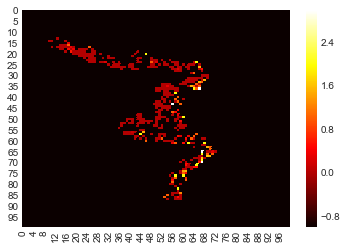

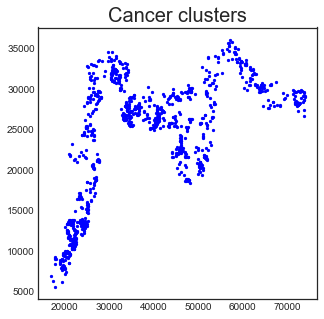

CD3 shape: (41281, 7)
CD8 shape: (26308, 7)
Clusters.shape: (1039, 7)
x.shape: (407520, 7) 


Code: 3301


100%|██████████| 100/100 [00:01<00:00, 60.36it/s]


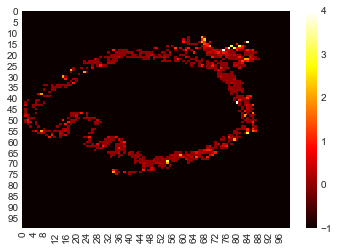

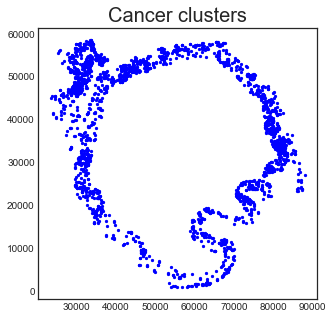

CD3 shape: (27190, 7)
CD8 shape: (26167, 7)
Clusters.shape: (2497, 7)
x.shape: (407520, 7) 


Code: 3302


100%|██████████| 100/100 [00:04<00:00, 22.38it/s]


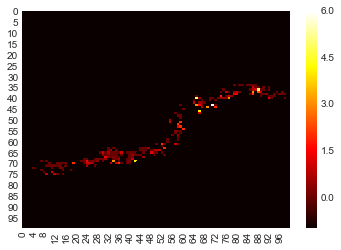

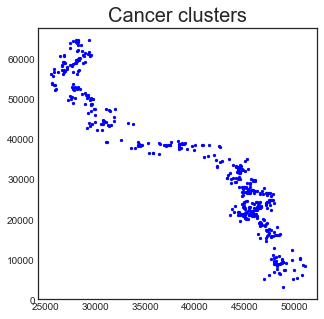

CD3 shape: (88450, 7)
CD8 shape: (56534, 7)
Clusters.shape: (453, 7)
x.shape: (407520, 7) 


Code: 3303


100%|██████████| 100/100 [00:01<00:00, 92.31it/s]


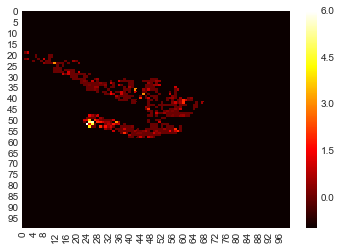

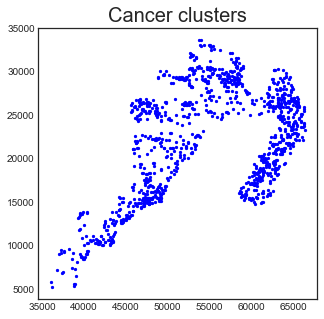

CD3 shape: (20606, 7)
CD8 shape: (5886, 7)
Clusters.shape: (1136, 7)
x.shape: (407520, 7) 


Code: 3304


100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


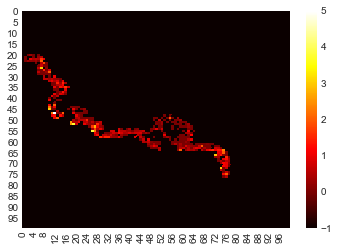

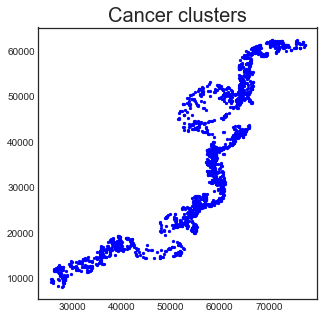

CD3 shape: (95691, 7)
CD8 shape: (43028, 7)
Clusters.shape: (1946, 7)
x.shape: (407520, 7) 


Code: 3305


100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


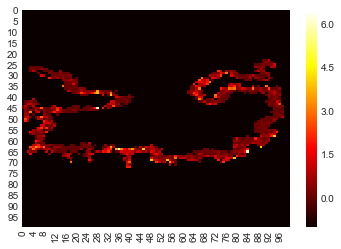

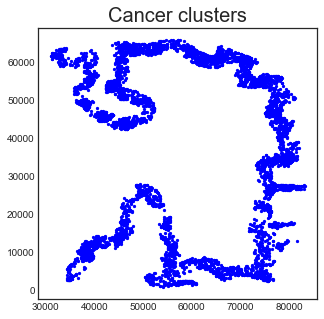

CD3 shape: (151530, 7)
CD8 shape: (95106, 7)
Clusters.shape: (6763, 7)
x.shape: (407520, 7) 


Code: 3307


100%|██████████| 100/100 [00:01<00:00, 68.09it/s]


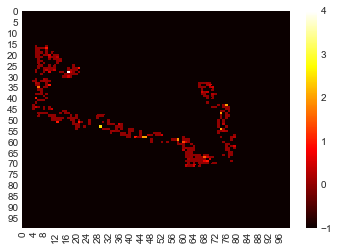

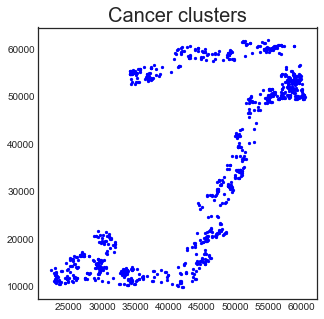

CD3 shape: (33243, 7)
CD8 shape: (10664, 7)
Clusters.shape: (1002, 7)
x.shape: (407520, 7) 


Code: 3308


100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


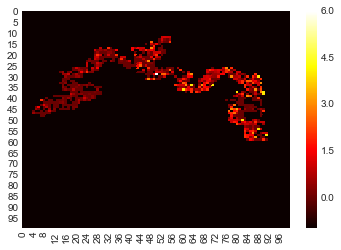

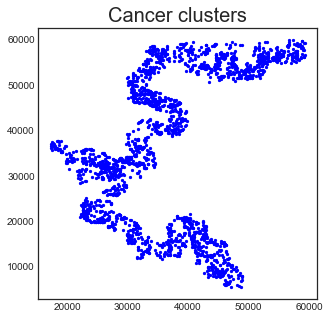

CD3 shape: (138732, 7)
CD8 shape: (63874, 7)
Clusters.shape: (2404, 7)
x.shape: (407520, 7) 


Code: ['SN16.czi_3042_job2807.object_results']


100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


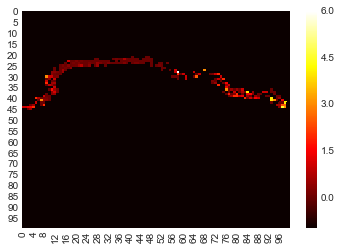

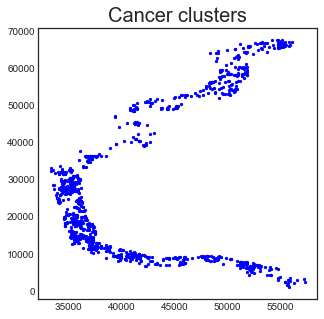

CD3 shape: (228070, 7)
CD8 shape: (74403, 7)
Clusters.shape: (1004, 7)
x.shape: (407520, 7) 


Code: ['SN20.czi_3043_job2808.object_results']


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


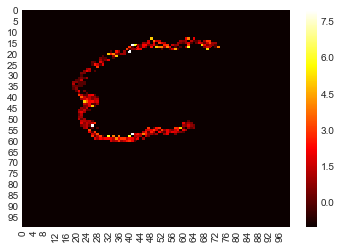

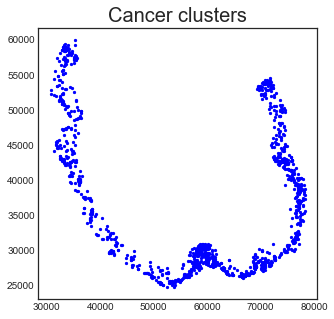

CD3 shape: (101288, 7)
CD8 shape: (407205, 7)
Clusters.shape: (1243, 7)
x.shape: (407520, 7) 




In [19]:
X = []
y = np.zeros([115, 1], dtype=int)

positives = []
positive_codes = [
                  "0736", "0711", "0769", "3304", "0793",
                  "3302", "0781", "0747", "3303", "0690",
                  "3305", "0703", "0805", "0733", "3301"
                 ]

# Specify the distance between cancer clusters and lymphocytes here, tiling parameter
Cluster.set_d(50)
t = 100

# Doing these file-pairs one at a time - they take up an insane amount of space! 
# We have a HUGE number of these lymphocytes.
for (i, lymph_name), (j, cluster_name) in zip(enumerate(sorted(glob.glob("./lymphocytes/*.csv"))), 
                                              enumerate(sorted(glob.glob("./LargerDataset/*.p")))):
    lymph_code = lymph_name.split('/')[-1][0:-4].split("__")
    cluster_code = cluster_name.split('/')[-1][0:-2].split("__")

    # No SN-- files are positive in our dataset - ignore these for potential positives
    if len(lymph_code) == len(cluster_code) and len(lymph_code) > 1:
        lymph_code = lymph_code[1][0:4]
        cluster_code = cluster_code[1][0:4]
        if lymph_code in positive_codes and lymph_code == cluster_code:
            positives.append(i)
            y[i] = 1
            
    print("Code:", lymph_code)

    cd3, cd8 = load_split(lymph_name.split('/')[-1][0:-4], "./lymphocytes/", input_type="lymphocyte", pretty_print=False)
    
    # Add the cluster class column
    cd3 = np.concatenate((cd3, np.zeros((cd3.shape[0], 1))), axis=1)
    cd8 = np.concatenate((cd8, np.zeros((cd8.shape[0], 1))), axis=1)
    
    # Get the clusters
    cancer_clusters = load_split(cluster_name.split('/')[-1][0:-2], "./LargerDataset/", input_type="cluster", pretty_print=False)
    
    # Add the cd3/cd8 class columns, filter for those with sizes in specified range (here it's 1-4, tumour buds)
    cancer_clusters = np.concatenate((cancer_clusters, 
                                      np.zeros((cancer_clusters.shape[0], 2)),
                                      np.ones((cancer_clusters.shape[0], 1))),
                                     axis=1)
    
    cancer_clusters = cancer_clusters[cancer_clusters[:,0] < 5]
    cancer_clusters = cancer_clusters[cancer_clusters[:,0] > 0]
    cancer_clusters = cancer_clusters[:, 1:]
    
    # Combine all of them together
    items = np.concatenate((cancer_clusters, cd3, cd8))

    partitioned_items, tiles, lymph_w, lymph_h = partition.partition(items, tile_size=t, to_list=True, input_type="mixed")

    ratios = Cluster.get_lymphocyte_cluster_ratio_heatmap(partitioned_items, t, tiles, lymph_w, lymph_h)
    
    with sb.axes_style("white"):
        heatmap = sb.heatmap(ratios, cmap="hot")
        visualise_new(cancer_clusters, size_included=False, size=(5, 5))
        plt.show()
    
    X.append(ratios)

    print("CD3 shape:", cd3.shape)
    print("CD8 shape:", cd8.shape)
    print("Clusters.shape:", cancer_clusters.shape)
    print("x.shape:", x.shape, "\n\n")